In [1]:
#imports
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#import data
df = pd.read_excel("reyesdata.xlsx")

In [2]:
#cleaning empty entries
empty_id = []
for index, row in df.iterrows():
    if (row['behaviors_all']==0) and (row['adas_all']==0) and (row['speeding_all']==0) and (row['accelerating_all']==0):
        empty_id.append(index)

In [3]:
print('There are ', len(empty_id), ' empty entries.')

There are  15356  empty entries.


In [4]:
print('Intial size: ', df.shape)
df = df.drop(empty_id)
print('Size after removing the empty entries is: ', df.shape)

Intial size:  (318573, 158)
Size after removing the empty entries is:  (303217, 158)


In [5]:
titles = df.columns.values
i=0
#print titles of the colums
for title in titles:
    i+=1
    print(i,'     ' ,title)

1       event_id
2       event_status
3       company_name
4       group_level_1
5       group_level_2
6       group_level_5
7       group_level_6
8       group_level_7
9       group_level_8
10       group_level_9
11       group_level_10
12       group_level_11
13       group_level_12
14       group_level_13
15       group_level_14
16       group_level_15
17       group_level_16
18       group_level_17
19       er_serial_number
20       vehicle_description
21       vehicle_type
22       driver_id
23       record_date
24       record_time
25       time_zone
26       record_date_utc
27       record_year
28       record_month
29       record_week
30       record_day
31       record_day_of_the_week
32       record_hour
33       record_yyyyww
34       record_yyyymm
35       latitude
36       longitude
37       event_score
38       scored_event
39       event_review_date_time_utc
40       coachable_event
41       coached_date_utc
42       behaviors_all
43       accelerating_all
44       acce

In [6]:
'''COLLISONS TIMEFRAME EST HEATMAP'''

collision_df_EST = df.loc[df['collision']==1][['collision', 'record_time', 'time_zone','record_day_of_the_week', 'event_score']]
collision_df_EST = collision_df_EST.reset_index()
collision_df_EST.head()

,index,collision,record_time,time_zone,record_day_of_the_week,event_score
0,791,1,02:24:15,CST,2,0
1,1015,1,03:52:05,CST,3,0
2,1201,1,04:16:22,EST,5,0
3,1667,1,12:37:36,CST,4,0
4,1668,1,04:16:17,EST,5,0


In [7]:

def return_timeframe_EST(record_time,time_zone):
    '''this function returns the time frame in EST
        IN
        RECORD_TIME: datetime.time type entry
        TIME_ZONE: EST, CST OR PST
        
        OUT
        TIME_FRAME: Hourly frame of the day 0-1 is 0...23-24 is 23
        ONE_MORE_DAY: Adds one day if it is midnight in EST
        
    '''
    one_more_day =0
    if time_zone == 'EST ':
        time_frame = record_time.hour
    elif time_zone == 'CST ':
        time_frame = record_time.hour+1
        if time_frame ==24:
            time_frame=0
            one_more_day = 1
    else:
        time_frame = record_time.hour+3
        if time_frame == 24:
            time_frame = 0
            one_more_day = 1
        elif time_frame == 25:            
            time_frame = 1
            one_more_day = 1
        elif time_frame == 26:
            time_frame = 2
            one_more_day = 1
    return time_frame, one_more_day

def day_week_correction(day_week, one_more_day):
    if one_more_day ==1:
        day_week+=1
        if day_week ==7:
            day_week = 0
    return day_week   

In [8]:
#creation of the time frames in EST in the dataset
dtf = []
actual_day = []
for index, row in collision_df_EST.iterrows():
    time_frame, one_more_day = return_timeframe_EST(row['record_time'], row['time_zone'])
    dtf.append(time_frame)
    actual_day.append(day_week_correction(row['record_day_of_the_week'], one_more_day))
collision_df_EST['time_frame_EST'] = pd.DataFrame(dtf)
collision_df_EST['actual_day'] = pd.DataFrame(actual_day)
collision_df_EST.head()

,index,collision,record_time,time_zone,record_day_of_the_week,event_score,time_frame_EST,actual_day
0,791,1,02:24:15,CST,2,0,3,2
1,1015,1,03:52:05,CST,3,0,4,3
2,1201,1,04:16:22,EST,5,0,4,5
3,1667,1,12:37:36,CST,4,0,13,4
4,1668,1,04:16:17,EST,5,0,4,5


In [9]:
#grouping by day of the week and time frame
collision_df_EST = collision_df_EST.groupby(['actual_day','time_frame_EST'])['collision'].sum()
collision_df_EST = collision_df_EST.reset_index()
collision_df_EST.head()

,actual_day,time_frame_EST,collision
0,0,0,2
1,0,2,1
2,0,3,1
3,0,4,2
4,0,6,3


In [10]:
#put the data in sns format

collision_sum_EST = collision_df_EST.pivot('actual_day', 'time_frame_EST', 'collision').fillna(0)
collision_sum_EST.rename(columns = {0:'0-1',1:'1-2',2:'2-3',3:'3-4',4:'4-5',5:'5-6',6:'6-7',7:'7-8',
                               8:'8-9',9:'9-10',10:'10-11',11:'11-12',12:'12-13',13:'13-14',14:'14-15',15:'15-16',
                               16:'16-17',17:'17-18',18:'18-19',19:'19-20',20:'20-21',21:'21-22',
                               22:'22-23',23:'23-24'}, index = {0:'Mon',1:'Tue',2:'Wed',
                                                                3:'Thu',4:'Fri',5:'Sat',6:'Sun'}, inplace=True)
collision_sum_EST

time_frame_EST,0-1,1-2,2-3,3-4,4-5,5-6,6-7,7-8,8-9,9-10,...,14-15,15-16,16-17,17-18,18-19,19-20,20-21,21-22,22-23,23-24
actual_day,,,,,,,,,,,,,,,,,,,,,
Mon,2.0,0.0,1.0,1.0,2.0,0.0,3.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
Tue,0.0,1.0,3.0,2.0,7.0,3.0,6.0,5.0,6.0,4.0,...,3.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,3.0
Wed,3.0,2.0,3.0,7.0,5.0,7.0,2.0,5.0,4.0,3.0,...,4.0,4.0,3.0,5.0,1.0,1.0,2.0,1.0,1.0,1.0
Thu,3.0,3.0,4.0,3.0,5.0,2.0,9.0,4.0,7.0,2.0,...,2.0,3.0,2.0,3.0,4.0,3.0,1.0,1.0,2.0,1.0
Fri,0.0,2.0,1.0,1.0,1.0,4.0,5.0,3.0,3.0,4.0,...,5.0,2.0,5.0,2.0,2.0,1.0,0.0,0.0,0.0,3.0
Sat,0.0,0.0,1.0,5.0,5.0,3.0,2.0,6.0,4.0,8.0,...,1.0,8.0,8.0,4.0,0.0,1.0,0.0,1.0,2.0,0.0
Sun,1.0,3.0,1.0,0.0,1.0,1.0,2.0,1.0,0.0,1.0,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


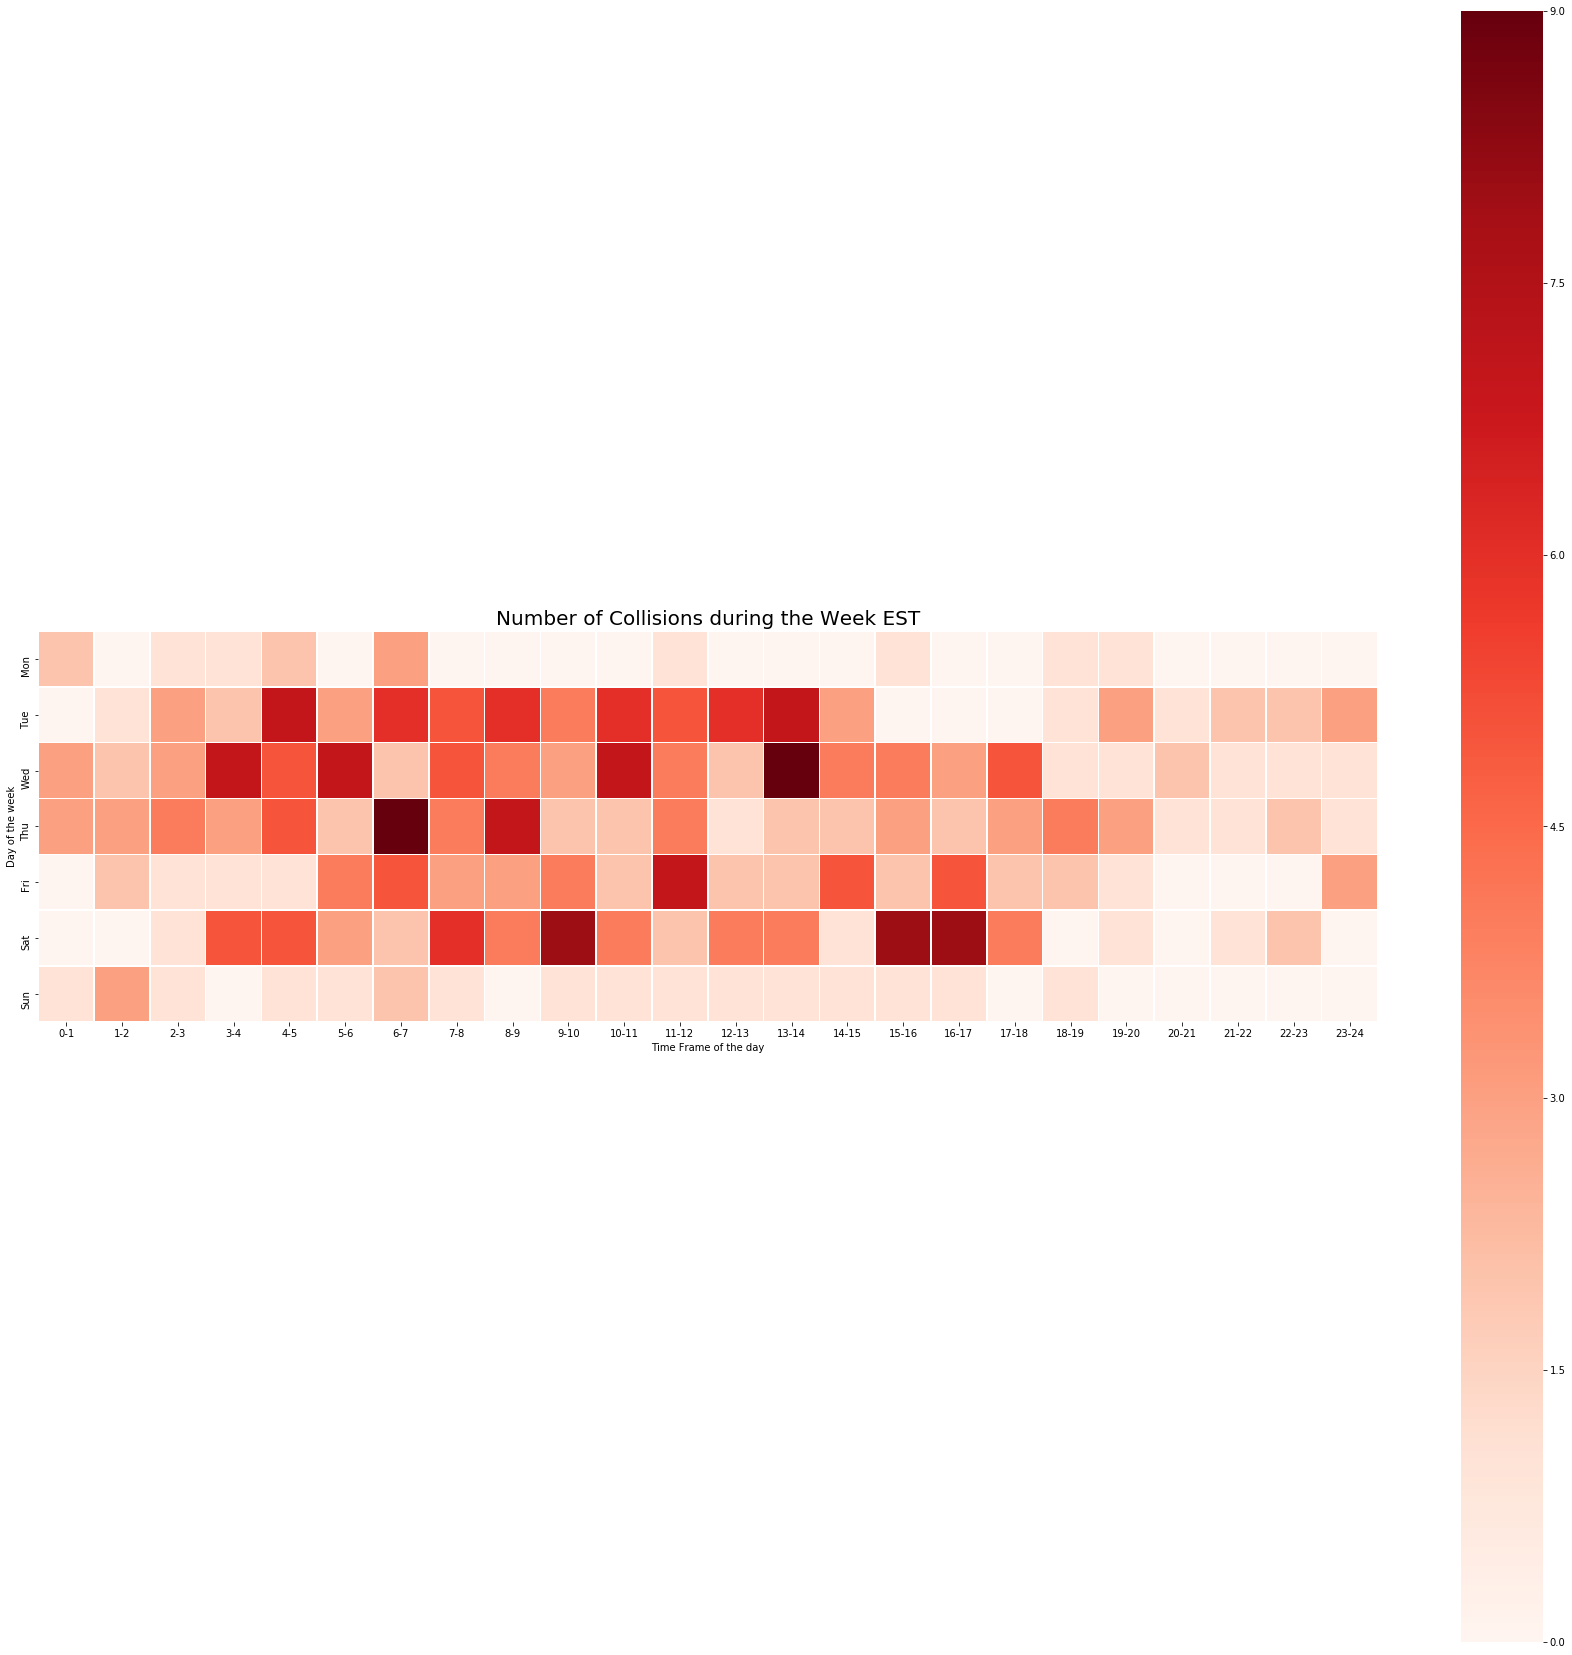

In [11]:
plt.figure(figsize=(30,30))
pivot_table = collision_sum_EST

plt.title('Number of Collisions during the Week EST', size = 20)

ax = sns.heatmap(pivot_table, annot = False, linewidth =.5, square= True,cmap='Reds')
ax.set(xlabel='Time Frame of the day', ylabel='Day of the week')
plt.show()

In [12]:
'''COLLISONS TIMEFRAME HEATMAP'''

def return_timeframe(record_time):
    '''this function returns the time frame 
        IN
        RECORD_TIME: datetime.time type entry        
        
        OUT
        TIME_FRAME: Hourly frame of the day 0-1 ...23-24        
        
    '''    
    return record_time.hour

In [13]:
collision_df = df.loc[df['collision']==1][['collision', 'record_time', 'time_zone','record_day_of_the_week', 'event_score']]
collision_df = collision_df.reset_index()
collision_df.head()

,index,collision,record_time,time_zone,record_day_of_the_week,event_score
0,791,1,02:24:15,CST,2,0
1,1015,1,03:52:05,CST,3,0
2,1201,1,04:16:22,EST,5,0
3,1667,1,12:37:36,CST,4,0
4,1668,1,04:16:17,EST,5,0


In [14]:
#creation of the time frames  in the dataset
dtf = []

for index, row in collision_df.iterrows():
    time_frame = return_timeframe(row['record_time'])
    dtf.append(time_frame)    
collision_df['time_frame'] = pd.DataFrame(dtf)
collision_df.head()

,index,collision,record_time,time_zone,record_day_of_the_week,event_score,time_frame
0,791,1,02:24:15,CST,2,0,2
1,1015,1,03:52:05,CST,3,0,3
2,1201,1,04:16:22,EST,5,0,4
3,1667,1,12:37:36,CST,4,0,12
4,1668,1,04:16:17,EST,5,0,4


In [15]:
#grouping by day of the week and time frame
collision_df = collision_df.groupby(['record_day_of_the_week','time_frame'])['collision'].sum()
collision_df = collision_df.reset_index()
collision_df.head()

,record_day_of_the_week,time_frame,collision
0,0,1,1
1,0,2,1
2,0,3,2
3,0,5,3
4,0,10,1


In [16]:
#put the data in sns format

collision_sum = collision_df.pivot('record_day_of_the_week', 'time_frame', 'collision').fillna(0)
collision_sum.head()

time_frame,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
record_day_of_the_week,,,,,,,,,,,,,,,,,,,,,
0,0.0,1.0,1.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,3.0,1.0,8.0,3.0,5.0,7.0,5.0,4.0,5.0,...,1.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,3.0,2.0
2,3.0,3.0,2.0,10.0,6.0,2.0,3.0,6.0,4.0,6.0,...,5.0,3.0,5.0,0.0,2.0,1.0,2.0,1.0,1.0,2.0
3,4.0,3.0,3.0,4.0,4.0,8.0,5.0,5.0,3.0,1.0,...,2.0,3.0,3.0,4.0,3.0,0.0,2.0,1.0,2.0,0.0
4,0.0,3.0,1.0,1.0,3.0,6.0,2.0,3.0,3.0,3.0,...,3.0,5.0,2.0,2.0,1.0,0.0,0.0,0.0,3.0,0.0


In [18]:
collision_sum.rename(columns = {0:'0-1',1:'1-2',2:'2-3',3:'3-4',4:'4-5',5:'5-6',6:'6-7',7:'7-8',
                               8:'8-9',9:'9-10',10:'10-11',11:'11-12',12:'12-13',13:'13-14',14:'14-15',15:'15-16',
                               16:'16-17',17:'17-18',18:'18-19',19:'19-20',20:'20-21',21:'21-22',
                               22:'22-23',23:'23-24'}, index = {0:'Mon',1:'Tue',2:'Wed',
                                                                3:'Thu',4:'Fri',5:'Sat',6:'Sun'}, inplace=True)
#collision_sum.to_excel('Collisions_week.xlsx')
collision_sum

time_frame,0-1,1-2,2-3,3-4,4-5,5-6,6-7,7-8,8-9,9-10,...,14-15,15-16,16-17,17-18,18-19,19-20,20-21,21-22,22-23,23-24
record_day_of_the_week,,,,,,,,,,,,,,,,,,,,,
Mon,0.0,1.0,1.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
Tue,0.0,3.0,1.0,8.0,3.0,5.0,7.0,5.0,4.0,5.0,...,1.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,3.0,2.0
Wed,3.0,3.0,2.0,10.0,6.0,2.0,3.0,6.0,4.0,6.0,...,5.0,3.0,5.0,0.0,2.0,1.0,2.0,1.0,1.0,2.0
Thu,4.0,3.0,3.0,4.0,4.0,8.0,5.0,5.0,3.0,1.0,...,2.0,3.0,3.0,4.0,3.0,0.0,2.0,1.0,2.0,0.0
Fri,0.0,3.0,1.0,1.0,3.0,6.0,2.0,3.0,3.0,3.0,...,3.0,5.0,2.0,2.0,1.0,0.0,0.0,0.0,3.0,0.0
Sat,0.0,1.0,4.0,4.0,3.0,3.0,5.0,6.0,6.0,5.0,...,7.0,7.0,6.0,0.0,0.0,1.0,1.0,2.0,0.0,1.0
Sun,2.0,2.0,0.0,1.0,1.0,2.0,1.0,0.0,1.0,1.0,...,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0


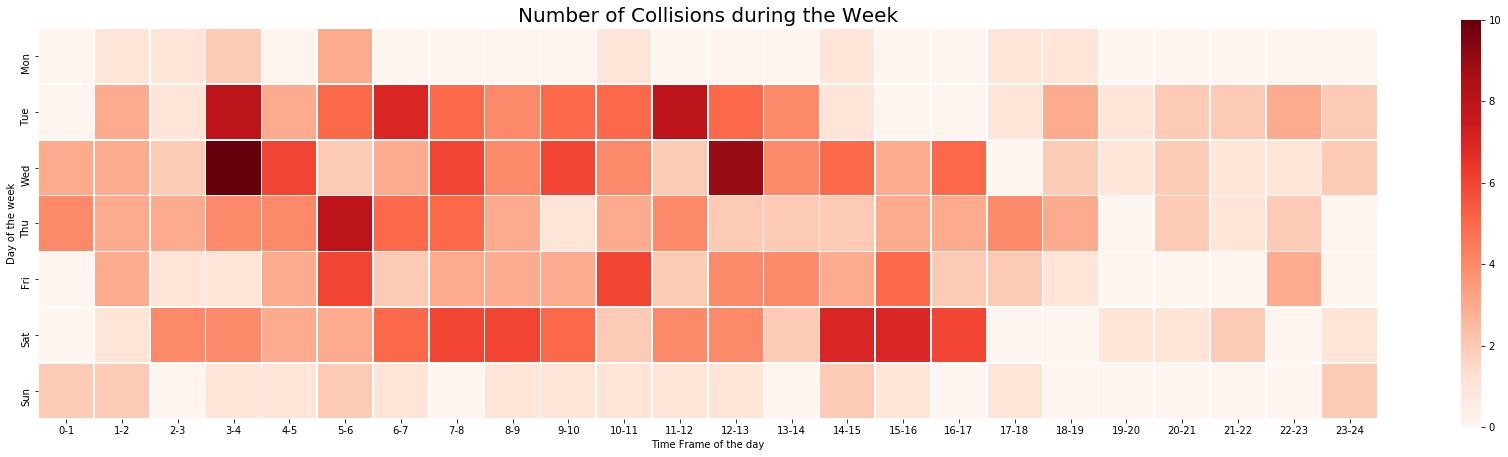

In [19]:
plt.figure(figsize=(30,30))
pivot_table = collision_sum

plt.title('Number of Collisions during the Week', size = 20)

ax = sns.heatmap(pivot_table, annot = False,cbar_kws={"shrink": .25} , linewidth =.5, square= True,cmap='Reds')
ax.set(xlabel='Time Frame of the day', ylabel='Day of the week')
plt.show()

In [20]:
'''SCORE TIMEFRAME EST HEATMAP'''
score_df_EST = df.loc[df['event_score']>0][[ 'record_time', 'time_zone','record_day_of_the_week', 'event_score']]
score_df_EST  = score_df_EST.reset_index()
score_df_EST.head()

,index,record_time,time_zone,record_day_of_the_week,event_score
0,6,13:32:47,CST,3,5
1,27,06:38:40,EST,2,4
2,68,13:23:38,CST,3,5
3,86,11:41:42,EST,4,4
4,107,03:16:08,CST,1,5


In [21]:
#creation of the time frames in EST in the dataset
dtf = []
actual_day = []
for index, row in score_df_EST.iterrows():
    time_frame, one_more_day = return_timeframe_EST(row['record_time'], row['time_zone'])
    dtf.append(time_frame)
    actual_day.append(day_week_correction(row['record_day_of_the_week'], one_more_day))
score_df_EST['time_frame_EST'] = pd.DataFrame(dtf)
score_df_EST['actual_day'] = pd.DataFrame(actual_day)
score_df_EST.head()

,index,record_time,time_zone,record_day_of_the_week,event_score,time_frame_EST,actual_day
0,6,13:32:47,CST,3,5,14,3
1,27,06:38:40,EST,2,4,6,2
2,68,13:23:38,CST,3,5,14,3
3,86,11:41:42,EST,4,4,11,4
4,107,03:16:08,CST,1,5,4,1


In [22]:
#grouping byt day of the week and time frame
score_sum_EST = score_df_EST.groupby(['actual_day','time_frame_EST'])['event_score'].sum()
score_sum_EST = score_sum_EST.reset_index()

score_sum_EST.head()

score_sum_EST =score_sum_EST.pivot('actual_day', 'time_frame_EST', 'event_score').fillna(0)
score_sum_EST.rename(columns = {0:'0-1',1:'1-2',2:'2-3',3:'3-4',4:'4-5',5:'5-6',6:'6-7',7:'7-8',
                               8:'8-9',9:'9-10',10:'10-11',11:'11-12',12:'12-13',13:'13-14',14:'14-15',15:'15-16',
                               16:'16-17',17:'17-18',18:'18-19',19:'19-20',20:'20-21',21:'21-22',
                               22:'22-23',23:'23-24'},index={0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',
                        4:'Friday',5:'Saturday',6:'Sunday'}, inplace=True)
score_sum_EST.head()

time_frame_EST,0-1,1-2,2-3,3-4,4-5,5-6,6-7,7-8,8-9,9-10,...,14-15,15-16,16-17,17-18,18-19,19-20,20-21,21-22,22-23,23-24
actual_day,,,,,,,,,,,,,,,,,,,,,
Monday,42,39,31,67,56,61,102,134,122,176,...,155,173,210,131,189,134,105,120,131,93
Tuesday,136,132,137,211,253,544,725,1144,1349,1325,...,1359,1266,1018,648,550,244,218,158,131,107
Wednesday,128,114,213,204,274,555,807,1383,1560,1445,...,1435,1246,983,862,485,388,221,113,129,174
Thursday,120,117,169,143,220,478,700,1203,1471,1482,...,1262,1119,971,875,574,333,192,180,158,177
Friday,164,120,143,152,341,522,734,1205,1299,1441,...,1344,1157,1131,858,640,319,288,233,159,131


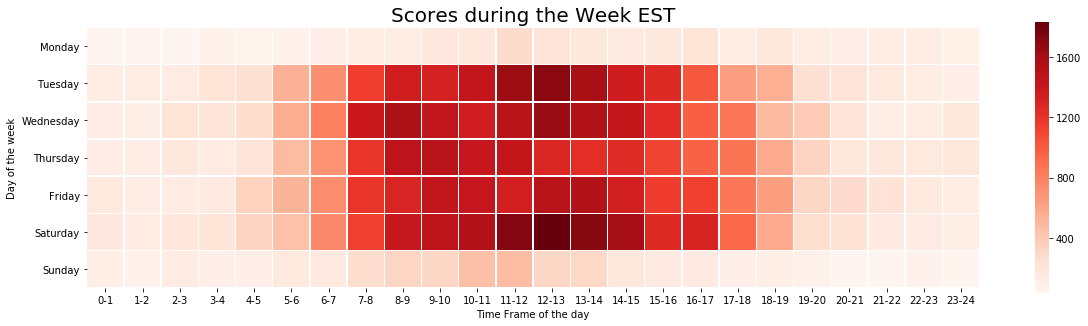

In [23]:
plt.figure(figsize=(20,20))
pivot_table = score_sum_EST

plt.title('Scores during the Week EST', size = 20)

ax = sns.heatmap(pivot_table, annot = False,cbar_kws={"shrink": .25} , linewidth =.5, square= True,cmap='Reds')
ax.set(xlabel='Time Frame of the day', ylabel='Day of the week')
plt.show()

In [24]:
score_df = df.loc[df['event_score']>0][[ 'record_time', 'time_zone','record_day_of_the_week', 'event_score']]
score_df = score_df.reset_index()
score_df.head()

,index,record_time,time_zone,record_day_of_the_week,event_score
0,6,13:32:47,CST,3,5
1,27,06:38:40,EST,2,4
2,68,13:23:38,CST,3,5
3,86,11:41:42,EST,4,4
4,107,03:16:08,CST,1,5


In [33]:
#creation of the time frames  in the dataset
dtf = []

for index, row in score_df.iterrows():
    time_frame = return_timeframe(row['record_time'])
    dtf.append(time_frame)    
score_df['time_frame'] = pd.DataFrame(dtf)
score_df.head()

,index,record_time,time_zone,record_day_of_the_week,event_score,time_frame
0,6,13:32:47,CST,3,5,13
1,27,06:38:40,EST,2,4,6
2,68,13:23:38,CST,3,5,13
3,86,11:41:42,EST,4,4,11
4,107,03:16:08,CST,1,5,3


In [34]:
#grouping by day of the week and time frame
score_sum = score_df.groupby(['record_day_of_the_week','time_frame'])['event_score'].sum()
score_sum = score_sum.reset_index()
score_sum.head()

,record_day_of_the_week,time_frame,event_score
0,0,0,29
1,0,1,38
2,0,2,67
3,0,3,56
4,0,4,64


In [35]:
#put the data in sns format

score_sum = score_sum.pivot('record_day_of_the_week', 'time_frame', 'event_score').fillna(0)
score_sum.rename(columns = {0:'0-1',1:'1-2',2:'2-3',3:'3-4',4:'4-5',5:'5-6',6:'6-7',7:'7-8',
                               8:'8-9',9:'9-10',10:'10-11',11:'11-12',12:'12-13',13:'13-14',14:'14-15',15:'15-16',
                               16:'16-17',17:'17-18',18:'18-19',19:'19-20',20:'20-21',21:'21-22',
                               22:'22-23',23:'23-24'}, index = {0:'Mon',1:'Tue',2:'Wed',
                                                                3:'Thu',4:'Fri',5:'Sat',6:'Sun'}, inplace=True)
#score_sum.to_excel('Score_week.xlsx')
score_sum.head()

time_frame,0-1,1-2,2-3,3-4,4-5,5-6,6-7,7-8,8-9,9-10,...,14-15,15-16,16-17,17-18,18-19,19-20,20-21,21-22,22-23,23-24
record_day_of_the_week,,,,,,,,,,,,,,,,,,,,,
Mon,29,38,67,56,64,102,125,124,176,161,...,157,187,158,182,132,93,125,139,77,134
Tue,125,133,194,229,435,722,1020,1396,1262,1375,...,1326,1023,753,595,273,236,160,108,124,123
Wed,111,183,210,236,457,768,1249,1538,1500,1368,...,1275,1029,919,565,400,222,118,121,144,132
Thu,130,164,141,189,379,673,1078,1393,1590,1504,...,1188,1038,896,650,324,196,200,148,196,136
Fri,120,160,128,295,458,642,1147,1262,1429,1442,...,1208,1266,909,661,329,291,237,158,140,162


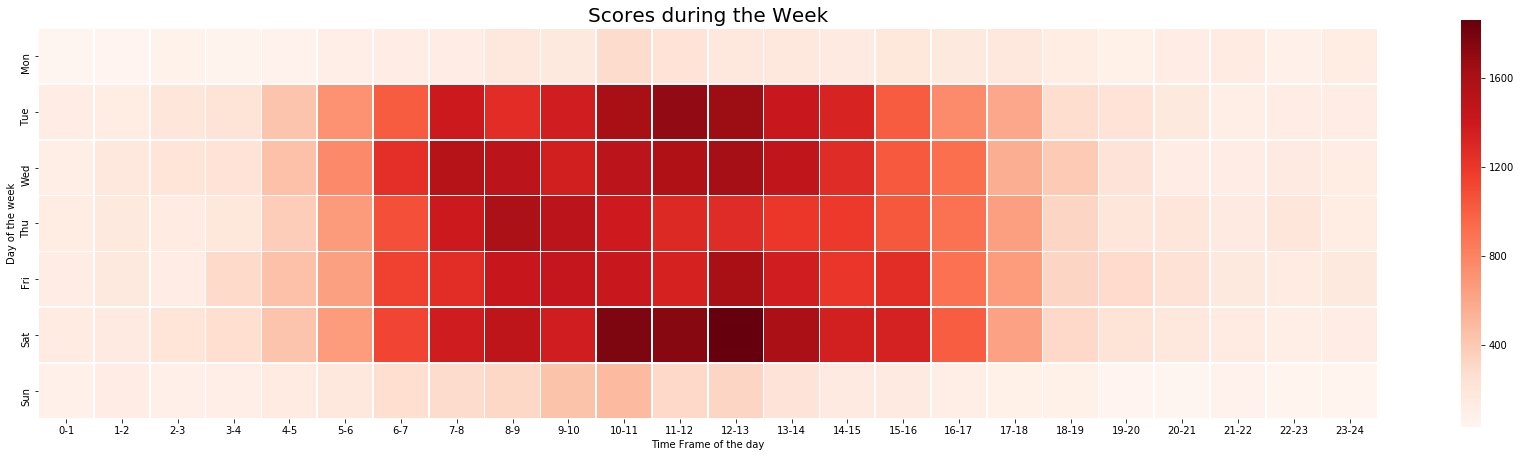

In [36]:
plt.figure(figsize=(30,30))
pivot_table = score_sum

plt.title('Scores during the Week', size = 20)

ax = sns.heatmap(pivot_table, annot = False,cbar_kws={"shrink": .25} ,  linewidth =.5, square= True,cmap='Reds')
ax.set(xlabel='Time Frame of the day', ylabel='Day of the week')
plt.show()

In [37]:
'''Collision and score vs Vehicle type'''
col_score = df.loc[df['collision']==1][['driver_id','collision', 'event_score']]
col_score = col_score.reset_index()
col_score = col_score.drop(columns = ['index'])
col_score.head()

,driver_id,collision,event_score
0,72360,1,0
1,120402,1,0
2,88751,1,0
3,29039,1,0
4,88751,1,0


In [38]:
#EVERY TIME THERE IS A COLLISION EVENT_SCORE IS 0
col_score = col_score.drop(columns = ['event_score'])

In [39]:
col_score = col_score.groupby(['driver_id'])['collision'].sum()
col_score = col_score.reset_index()
col_score.head()

,driver_id,collision
0,6,1
1,10255,1
2,10285,1
3,12138,1
4,12152,1


In [40]:
col_score.shape

(336, 2)

In [41]:
for index, row in col_score.iterrows():
    if row['collision']>1:
        print('The driver: ', row['driver_id'], 'had ', row['collision'], ' collisions')
        driver_df = df.loc[df['driver_id']==row['driver_id']]
        print('The driver',row['driver_id'] ,'has', driver_df.shape[0],' entries in the datasets')
        driver_df = driver_df.loc[df['coached_date_utc'].notnull()]
        print('The driver', row['driver_id'],'has been coached', driver_df.shape[0],' times in 2018 \n')

The driver:  22262 had  2  collisions
The driver 22262 has 75  entries in the datasets
The driver 22262 has been coached 1  times in 2018 

The driver:  26921 had  2  collisions
The driver 26921 has 132  entries in the datasets
The driver 26921 has been coached 18  times in 2018 

The driver:  43509 had  2  collisions
The driver 43509 has 2  entries in the datasets
The driver 43509 has been coached 0  times in 2018 

The driver:  51390 had  2  collisions
The driver 51390 has 104  entries in the datasets
The driver 51390 has been coached 12  times in 2018 

The driver:  58523 had  2  collisions
The driver 58523 has 111  entries in the datasets
The driver 58523 has been coached 9  times in 2018 

The driver:  62764 had  2  collisions
The driver 62764 has 8  entries in the datasets
The driver 62764 has been coached 2  times in 2018 

The driver:  69443 had  2  collisions
The driver 69443 has 20  entries in the datasets
The driver 69443 has been coached 4  times in 2018 

The driver:  7912

In [42]:
''' Score vs Driver'''
driver_score = df.loc[df['scored_event']==1][['driver_id', 'event_score','scored_event','collision']]
driver_score = driver_score.reset_index()
print(driver_score.shape)
print('Number of unique drivers:', driver_score.driver_id.unique().shape)
driver_score = driver_score.fillna(0)
driver_score.head()

(22805, 5)
Number of unique drivers: (4967,)


,index,driver_id,event_score,scored_event,collision
0,6,86163,5,1,0
1,27,87809,4,1,0
2,68,0,5,1,0
3,86,110863,4,1,0
4,107,86949,5,1,0


In [43]:
#driver_score = driver_score.groupby(['driver_id'])[['driver_id', 'event_score']]
driver_score [ 'driver_id'] = pd.to_numeric(driver_score['driver_id'])


ValueError: Unable to parse string "Temp 2 K003" at position 598

In [44]:
#not all the driver licenses are numbers
for index, row in driver_score.iterrows():
    try:
        int(row['driver_id'])
    except ValueError:
        print(row['driver_id'])

Temp 2 K003
Temp 5
Temp 5
Temp K003
None
None
GL006952
None
GL006952
None
None
None
FVTK
FVTK
FVTK


In [45]:
import collections
dscore = collections.defaultdict(int)
dsco_col = collections.defaultdict(int)
for index, row in driver_score.iterrows():
    dscore[row['driver_id']] +=row['event_score'] 
    dsco_col[row['driver_id']]+= row['collision'] 

In [46]:
top_scorers = {}
keystop=[]
for key, value in dscore.items():
    if value>80:
        top_scorers[key] = value 
        keystop.append(key)
print(top_scorers)
for key in keystop:
    print('Driver: ', key, ' has ', dsco_col[key],'collisions')
print('Out of the top ', len(keystop)-1, ' scorers NOT A SINGLE ONE  had a collision')

{0: 6500, 50180: 92, 44101: 88, 30055: 101, 123456: 164, 12742: 82, 121263: 118, 84923: 84, 46127: 86, 118953: 145, 120187: 92, 74326: 90, 110942: 95, 23014: 85, 86342: 89, 88364: 91, 82900: 85, 82941: 150, 57873: 83, 86338: 93, 20893: 89, 77296: 91, 60793: 87, 78103: 107, 77928: 82, 121425: 144, 121103: 83, 121525: 100, 119196: 83, 72156: 84, 121696: 99, 84424: 99, 73681: 105, 110834: 107, 120960: 88, 120333: 87, 75976: 84, 111096: 81, 50704: 102, 86276: 104, 121702: 114, 21347: 86, 50216: 88, 121983: 84, 79747: 83, 123041: 105, 120207: 83, 66446: 87, 123029: 103, 122984: 173, 122642: 104, 124174: 124, 123403: 81, 124634: 85, 3: 102, 5: 105}
Driver:  0  has  0 collisions
Driver:  50180  has  0 collisions
Driver:  44101  has  0 collisions
Driver:  30055  has  0 collisions
Driver:  123456  has  0 collisions
Driver:  12742  has  0 collisions
Driver:  121263  has  0 collisions
Driver:  84923  has  0 collisions
Driver:  46127  has  0 collisions
Driver:  118953  has  0 collisions
Driver:  1

In [47]:
driver_score = driver_score.sort_values(by = ['event_score'], ascending = False)
driver_score.head()

,index,driver_id,event_score,scored_event,collision
12815,183005,3,16,1,0
7690,122508,51537,15,1,0
9618,145160,82774,15,1,0
1121,21180,82727,15,1,0
15404,211120,49454,15,1,0


In [48]:
driver_score.groupby(['driver_id']).head()

,index,driver_id,event_score,scored_event,collision
12815,183005,3,16,1,0
7690,122508,51537,15,1,0
9618,145160,82774,15,1,0
1121,21180,82727,15,1,0
15404,211120,49454,15,1,0
15113,208079,52285,15,1,0
1663,32089,110693,15,1,0
11424,166800,81328,15,1,0
8158,127861,121920,15,1,0
1145,21648,69588,15,1,0


In [49]:
#number of times a driver has a scored event
times_scored = driver_score['driver_id'].value_counts()
times_scored = times_scored.reset_index()
times_scored.head(25)



,index,driver_id
0,0,1455
1,123456,39
2,82941,34
3,118953,34
4,122984,33
5,121425,28
6,86342,27
7,121263,27
8,73681,27
9,86338,26


In [50]:
dtimes_sco = collections.defaultdict(int)
dsco_col = collections.defaultdict(int)
for index, row in times_scored.iterrows():
    dtimes_sco[row['index']] +=row['driver_id'] 

In [51]:
top_times= {}
keystop=[]
for key, value in dtimes_sco.items():
    if value>15:
        top_scorers[key] = value 
        keystop.append(key)
print(top_scorers)
for key in keystop:
    print('Driver: ', key, ' has ', dsco_col[key],'collisions')
print('Out of the top ', len(keystop)-1, ' drivers scored the most times NOT A SINGLE ONE had a collision.')

{0: 1455, 50180: 20, 44101: 20, 30055: 20, 123456: 39, 12742: 17, 121263: 27, 84923: 84, 46127: 19, 118953: 34, 120187: 17, 74326: 20, 110942: 22, 23014: 17, 86342: 27, 88364: 22, 82900: 20, 82941: 34, 57873: 17, 86338: 26, 20893: 19, 77296: 20, 60793: 16, 78103: 23, 77928: 16, 121425: 28, 121103: 22, 121525: 24, 119196: 83, 72156: 20, 121696: 19, 84424: 25, 73681: 27, 110834: 25, 120960: 20, 120333: 21, 75976: 17, 111096: 17, 50704: 19, 86276: 20, 121702: 26, 21347: 18, 50216: 18, 121983: 18, 79747: 17, 123041: 21, 120207: 18, 66446: 22, 123029: 22, 122984: 33, 122642: 22, 124174: 25, 123403: 18, 124634: 85, 3: 19, 5: 20, 83195: 22, 82574: 21, 71748: 21, 51527: 20, 86893: 20, 121549: 20, 12752: 20, 82756: 20, 83081: 19, 26962: 19, 82639: 19, 88363: 19, 12173: 19, 62079: 19, 65314: 18, 68006: 18, 71418: 18, 14546: 18, 110863: 18, 45922: 18, 34912: 18, 86988: 17, 82820: 17, 82689: 17, 19307: 17, 16074: 17, 81944: 17, 54068: 17, 18463: 17, 120008: 17, 83145: 17, 118693: 17, 37836: 17, 18

In [52]:
'''STATE vs MONTH'''
import string

def return_state_or_city (location, gl_6):
    if location[-2:].isupper():
        #print(location[-2:])
        state = location[-2:]
    elif gl_6[-2:].isupper():
        state = gl_6[-2:]
    else:
        state = gl_6
    return state

In [53]:
state_month = df[['group_level_5', 'group_level_6','record_month', 'collision', 'event_score','camera_issue','driver_id','er_obstruction']]
state_month.reset_index()
state_month.head()


,group_level_5,group_level_6,record_month,collision,event_score,camera_issue,driver_id,er_obstruction
0,"Milwaukee, WI",NaN,1,0,0,0,NaN,0
1,"Harriman, NY",NaN,1,0,0,1,73585,0
2,"Stockton, CA",NaN,1,0,0,0,87331,0
3,"Milwaukee, WI",NaN,1,0,0,0,49154,0
4,"Tidewater, VA",NaN,1,0,0,0,NaN,0


In [54]:
state_month['group_level_6'].unique()

array([nan, 'Sylmar', 'Doral', 'Chicago, IL', 'Huntington Beach',
       'San Diego, CA', 'San Bernardino', 'Orlando, FL', 'Chesapeake, VA',
       'Pompano Beach', 'Highland Park - Field Services', 'Gardena',
       'Rockland Key', 'Aurora', 'Ventura', 'Fredrick, MD',
       'Washington DC', 'Bay City - Field Services',
       'Grand Rapids - Field Services', 'Kalamazoo - Field Services',
       'La Crosse Bev/Chem', 'Johnson City Bev/Chem',
       'Tidewater Bev/Chem', 'Omaha Bev/Chem', 'Twin Cities Bev/Chem',
       'Burlington Bev/Chem', 'Cincinnati Bev/Chem',
       'Bowling Green Bev/Chem', 'Marquette Bev/Chem', 'Boston Bev/Chem',
       'Pittsburgh Bev/Chem', 'Knoxville Bev/Chem', 'Eastern PA Bev/Chem',
       'Valdosta Bev/Chem', 'Shawano Bev/Chem',
       'Traverse City - Field Services', 'Marshall Bev/Chem',
       'New Orleans Bev/Chem', 'Milwaukee Bev/Chem',
       'Cedar Rapids Bev/Chem', 'Shreveport Bev/Chem',
       'Kansas City Bev/Chem', 'Santa Fe Springs',
       'Fli

In [55]:
state_month['group_level_5'].unique()

array(['Milwaukee, WI', 'Harriman, NY', 'Stockton, CA', 'Tidewater, VA',
       'Conroe, TX', 'Harbor Distributing', 'Boston, MA',
       'Gold Coast Beverage', 'Chicago Beverage', 'Wrightstown, WI',
       'Park City, IL', 'Eastern PA', 'Twin Cities, MN', 'Pittsburgh, PA',
       'Fairfield, OH', 'La Crosse, WI', 'Springfield, VT',
       'St. Johns, MI', 'Omaha, NE', 'Crest', 'Burlington, VT',
       'Grand Rapids, MI', 'Coatesville, PA', 'Detroit, MI',
       'Florida Distributing', 'Knoxville, TN', 'Chesbay',
       'Pompano Beach, FL', 'Cincinnati, OH', 'Orlando, FL',
       'Baton Rouge, LA', 'Mason City, IA', 'Michigan Field Services',
       'Atlanta, GA', 'Traverse City, MI', 'Highland Park, MI',
       'Valdosta, GA', 'Manassas, VA', 'Dickson, TN', 'Plover, WI',
       'Marquette, MI', 'Flint, MI', nan, 'Van Buren, MI',
       'St. Charles, IL', 'Salt Lake City, UT', 'Dallas/Ft. Worth, TX',
       'Shreveport, LA', 'Eagan, MN', 'New Orleans, LA',
       'Bowling Green, KY', '

In [56]:
print(return_state_or_city(state_month.iloc[0]['group_level_5'], state_month.iloc[0]['group_level_6']))

WI


In [57]:
states=[]
for index, row in state_month.iterrows():
    try:
        states.append(return_state_or_city(row['group_level_5'],row['group_level_6']))
    except TypeError:
        states.append('Unknown')
states = pd.DataFrame(states)


In [58]:
state_month['state'] = states
state_month.head(10)

C:\Users\alonso\Anaconda3\envs\machine_learning\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,group_level_5,group_level_6,record_month,collision,event_score,camera_issue,driver_id,er_obstruction,state
0,"Milwaukee, WI",NaN,1,0,0,0,NaN,0,WI
1,"Harriman, NY",NaN,1,0,0,1,73585,0,NY
2,"Stockton, CA",NaN,1,0,0,0,87331,0,CA
3,"Milwaukee, WI",NaN,1,0,0,0,49154,0,WI
4,"Tidewater, VA",NaN,1,0,0,0,NaN,0,VA
5,"Milwaukee, WI",NaN,1,0,0,0,110398,0,WI
6,"Milwaukee, WI",NaN,1,0,5,0,86163,0,WI
7,"Milwaukee, WI",NaN,1,0,0,0,120034,0,WI
8,"Milwaukee, WI",NaN,1,0,0,0,NaN,0,WI
9,"Milwaukee, WI",NaN,1,0,0,0,NaN,0,WI


In [59]:
state_month['state'].unique()

array(['WI', 'NY', 'CA', 'VA', 'TX', 'Sylmar', 'MA', 'Doral', 'IL', 'PA',
       'MN', 'OH', 'VT', 'MI', 'NE', 'Huntington Beach', 'San Bernardino',
       'FL', 'TN', 'Pompano Beach', 'LA', 'IA',
       'Highland Park - Field Services', 'GA', 'Gardena', 'Rockland Key',
       'Unknown', 'UT', 'KY', 'CT', 'Aurora', 'Ventura', 'MO', 'AR', 'MD',
       'Bay City - Field Services', 'Grand Rapids - Field Services',
       'Kalamazoo - Field Services', 'La Crosse Bev/Chem',
       'Tidewater Bev/Chem', 'Johnson City Bev/Chem', 'Omaha Bev/Chem',
       'Twin Cities Bev/Chem', 'Burlington Bev/Chem',
       'Cincinnati Bev/Chem', 'Bowling Green Bev/Chem',
       'Marquette Bev/Chem', 'Boston Bev/Chem', 'Pittsburgh Bev/Chem',
       'Knoxville Bev/Chem', 'Eastern PA Bev/Chem', 'Valdosta Bev/Chem',
       'Shawano Bev/Chem', 'Traverse City - Field Services',
       'Marshall Bev/Chem', 'New Orleans Bev/Chem', 'Milwaukee Bev/Chem',
       'Cedar Rapids Bev/Chem', 'Shreveport Bev/Chem',
       'Ka

In [60]:
#OBSTRUCTIOOOOOOOOOOOOOOOOONS

obs_issue_df = pd.DataFrame([])

for index, row in state_month.iterrows():
    if row['er_obstruction']>0:
        #print('+1')
        obs_issue_df = obs_issue_df.append(row, ignore_index = True)


In [61]:
obs_issue_df.head()

,camera_issue,collision,driver_id,er_obstruction,event_score,group_level_5,group_level_6,record_month,state
0,1.0,0.0,NaN,1.0,0.0,"Tidewater, VA",NaN,1.0,CA
1,0.0,0.0,78086,1.0,0.0,"Conroe, TX",NaN,1.0,VA
2,0.0,0.0,NaN,1.0,0.0,"Fairfield, OH",NaN,1.0,WI
3,0.0,0.0,119128,1.0,0.0,"Tidewater, VA",NaN,1.0,CA
4,0.0,0.0,63237,1.0,0.0,"Milwaukee, WI",NaN,1.0,MI


In [62]:
obs_issue_df1 = obs_issue_df.groupby(['record_month','state'])['er_obstruction'].sum()

obs_issue_df1 = obs_issue_df1.reset_index()

obs_issue_df1.head()

,record_month,state,er_obstruction
0,1.0,AR,1.0
1,1.0,CA,9.0
2,1.0,CT,1.0
3,1.0,Doral,4.0
4,1.0,FL,4.0


C:\Users\alonso\Anaconda3\envs\machine_learning\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


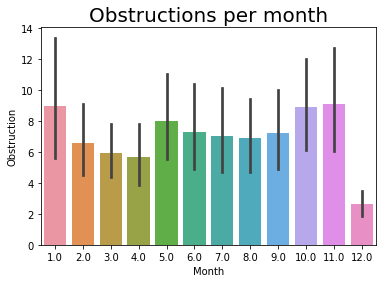

In [63]:
plt.title('Obstructions per month', size = 20)
ax = sns.barplot(x=obs_issue_df1.record_month, y=obs_issue_df1.er_obstruction)
ax.set(xlabel='Month', ylabel='Obstruction')
plt.show()

In [64]:
#lstates_not_top = [x for x in lstates_all if x not in lstates_top]
obs_issue_df = obs_issue_df.groupby(['record_month','state'])['er_obstruction'].sum()

obs_issue_df = obs_issue_df.reset_index()
obs_issue_df = obs_issue_df.loc[obs_issue_df1['er_obstruction']>10]
obs_issue_df1.head()


,record_month,state,er_obstruction
0,1.0,AR,1.0
1,1.0,CA,9.0
2,1.0,CT,1.0
3,1.0,Doral,4.0
4,1.0,FL,4.0


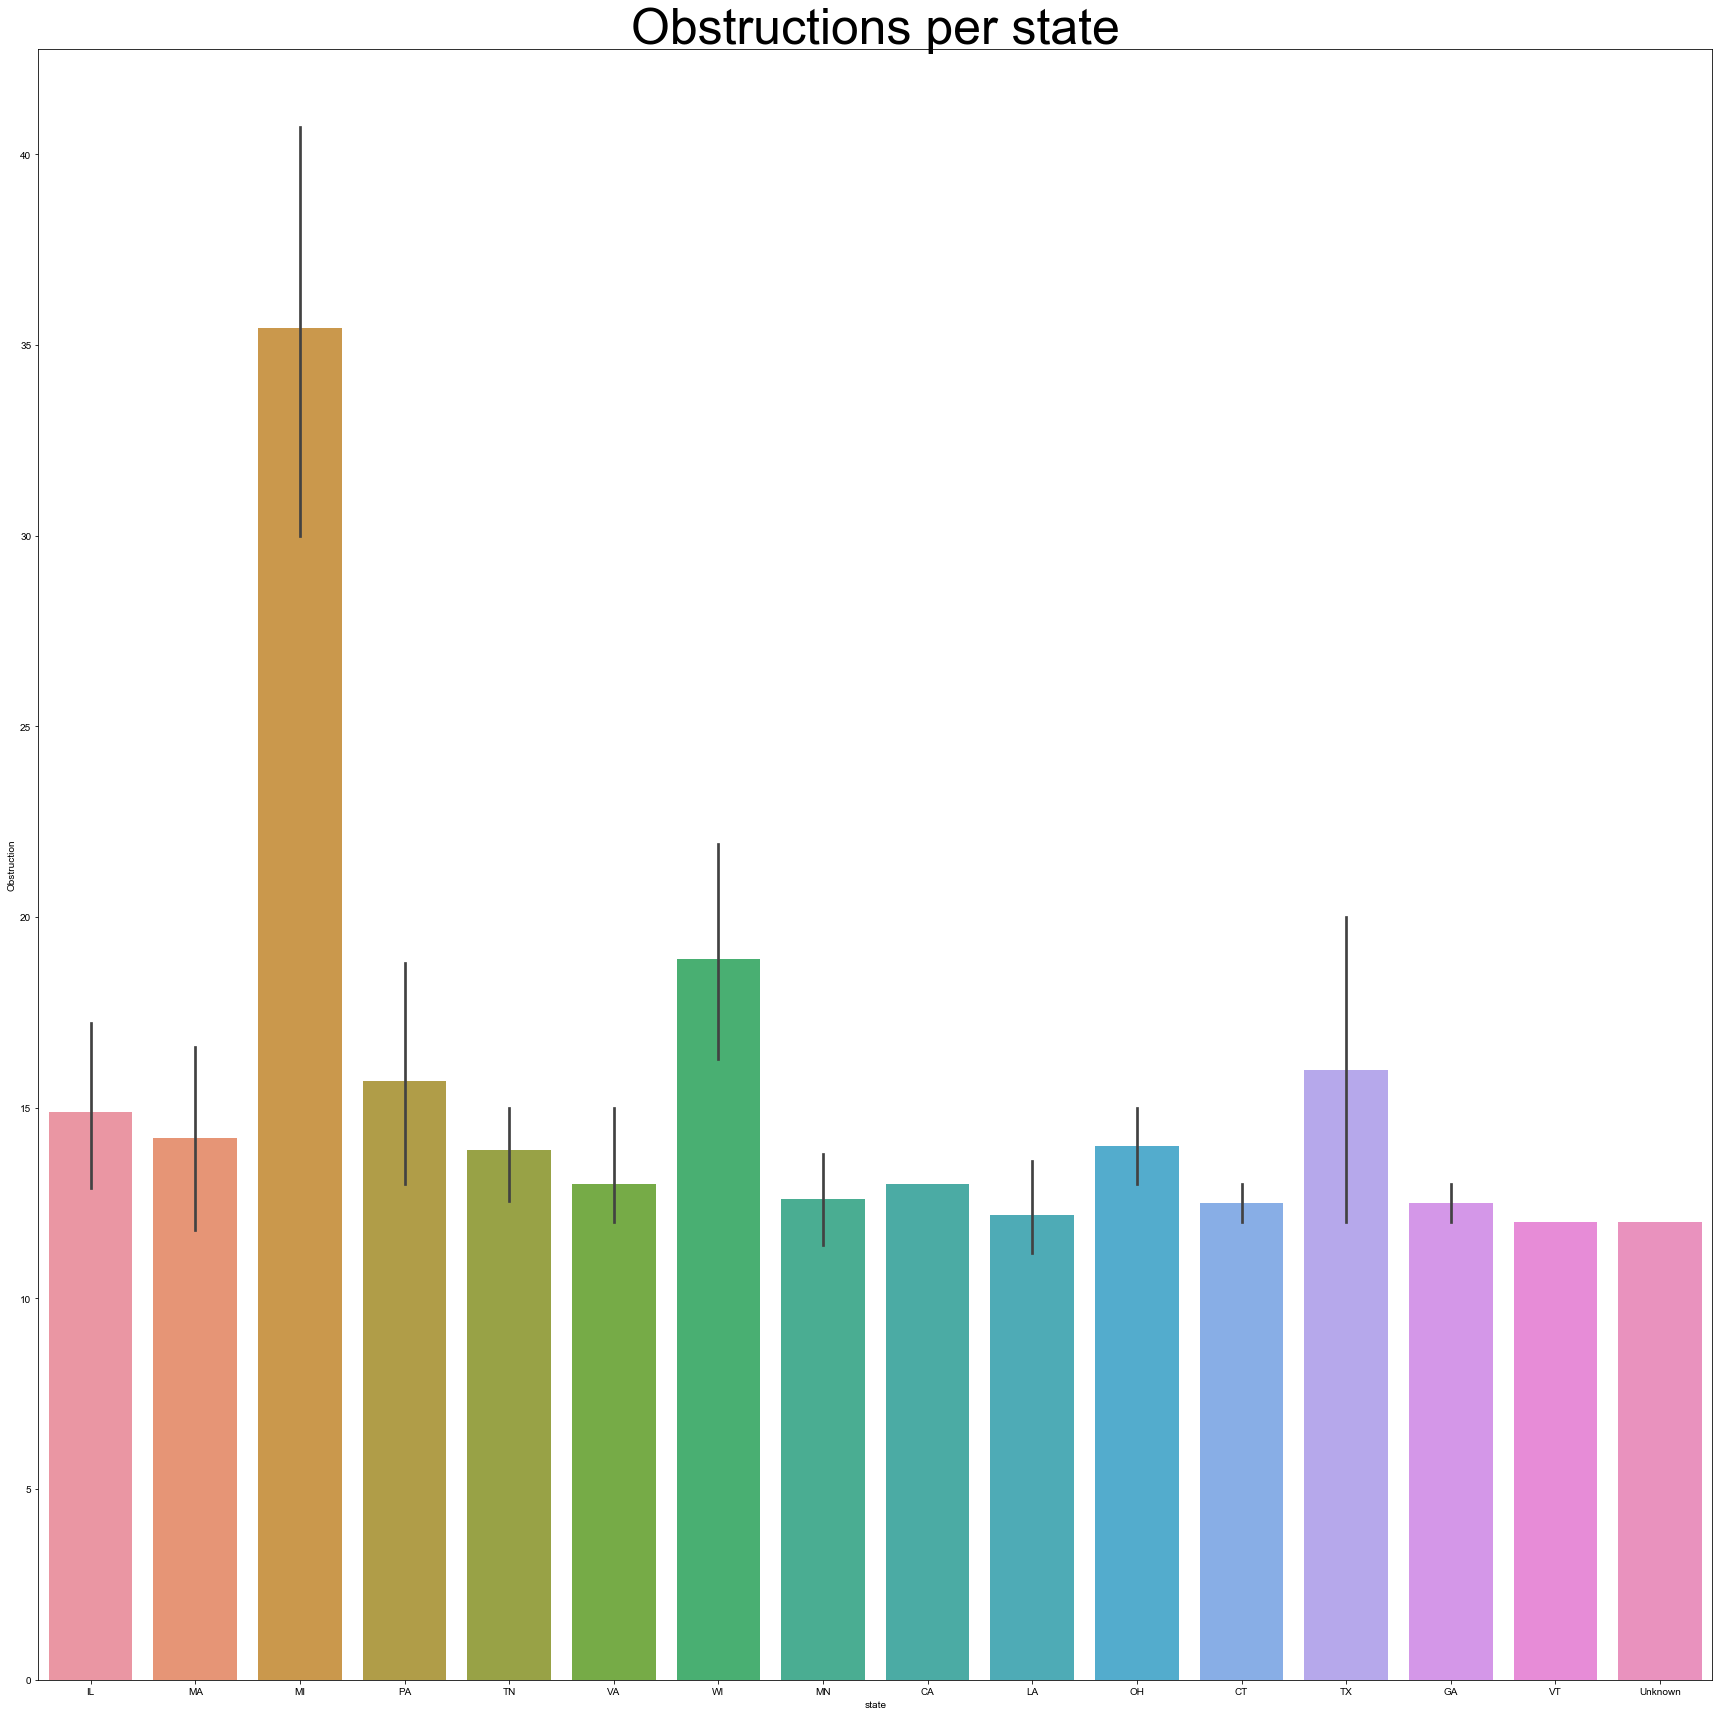

In [65]:
plt.figure(figsize=(30,30))
plt.title('Obstructions per state', size = 50)
ax = sns.barplot(x=obs_issue_df.state, y=obs_issue_df.er_obstruction)
ax.set(xlabel='state', ylabel='Obstruction')
# Bigger than normal fonts
sns.set(font_scale=5)
plt.show()

In [66]:
obs_issue_df = obs_issue_df.groupby(['record_month','state'])['er_obstruction'].sum()
obs_issue_df = obs_issue_df.reset_index()
obs_issue_df.head()

,record_month,state,er_obstruction
0,1.0,IL,14.0
1,1.0,MA,19.0
2,1.0,MI,46.0
3,1.0,PA,14.0
4,1.0,TN,15.0


In [67]:
#pivot_table = state_month_col.pivot('record_month', 'record_month', 'collision')

pivot_table = obs_issue_df.pivot(obs_issue_df.columns[0], obs_issue_df.columns[1], obs_issue_df.columns[2]).fillna(0)
pivot_table

state,CA,CT,GA,IL,LA,MA,MI,MN,OH,PA,TN,TX,Unknown,VA,VT,WI
record_month,,,,,,,,,,,,,,,,
1.0,0.0,0.0,0.0,14.0,0.0,19.0,46.0,0.0,0.0,14.0,15.0,0.0,0.0,12.0,0.0,30.0
2.0,0.0,0.0,0.0,11.0,0.0,0.0,31.0,11.0,0.0,18.0,11.0,0.0,0.0,0.0,0.0,16.0
3.0,13.0,0.0,0.0,13.0,0.0,15.0,24.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,13.0
4.0,0.0,0.0,0.0,11.0,11.0,0.0,20.0,0.0,0.0,16.0,13.0,0.0,0.0,0.0,0.0,15.0
5.0,0.0,0.0,0.0,18.0,12.0,0.0,43.0,13.0,14.0,11.0,11.0,0.0,0.0,0.0,0.0,22.0
6.0,0.0,13.0,0.0,17.0,0.0,0.0,37.0,14.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0
7.0,0.0,0.0,0.0,0.0,0.0,11.0,41.0,0.0,0.0,11.0,16.0,0.0,0.0,0.0,0.0,14.0
8.0,0.0,0.0,0.0,0.0,11.0,0.0,28.0,11.0,0.0,12.0,13.0,12.0,0.0,0.0,0.0,25.0
9.0,0.0,0.0,0.0,15.0,0.0,12.0,29.0,0.0,0.0,21.0,16.0,0.0,0.0,0.0,0.0,16.0


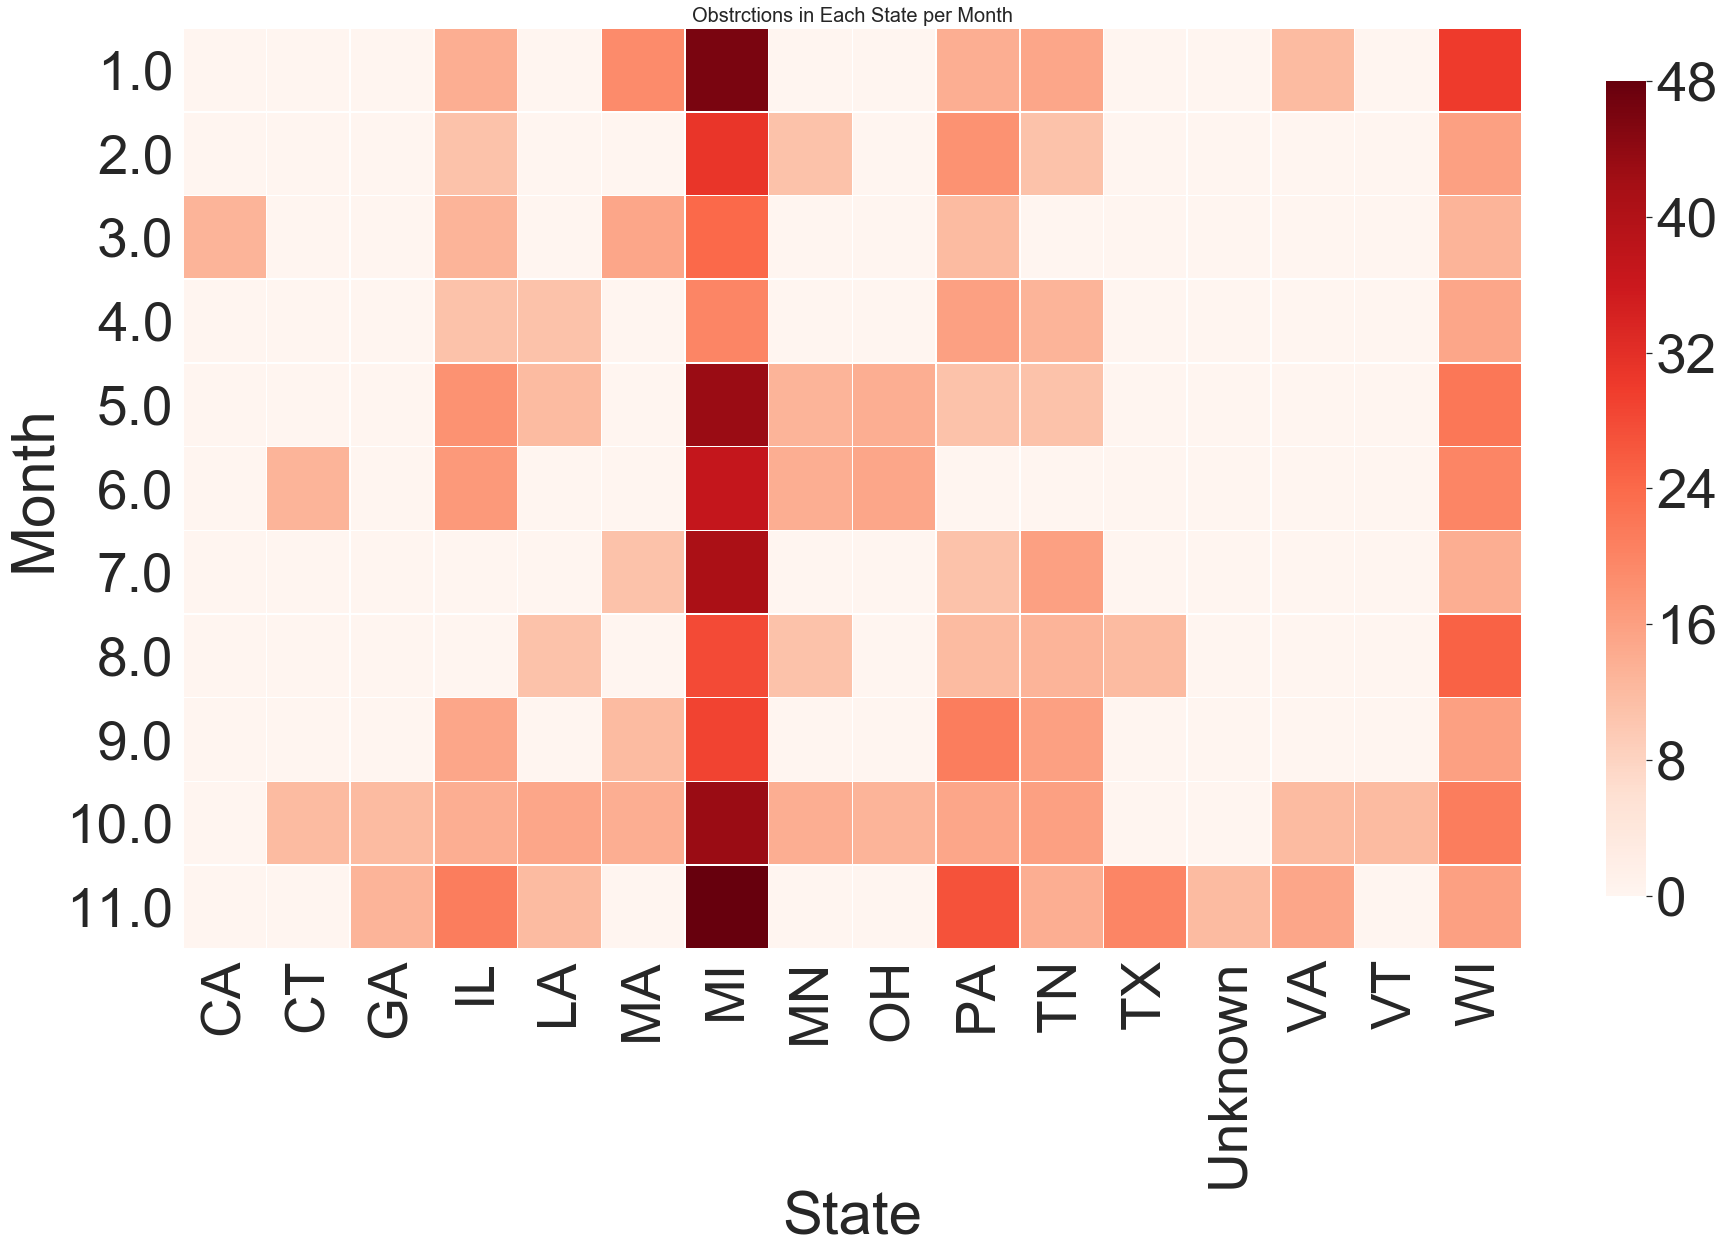

In [68]:
plt.figure(figsize=(30,30))
plt.title('Obstrctions in Each State per Month', size = 20)
ax = sns.heatmap(pivot_table, annot = False,cbar_kws={"shrink": .5},  linewidth =.5, square= True,cmap='Reds')
ax.set(xlabel='State', ylabel='Month')
plt.show()

In [69]:
#CAMERA ISSUEESSSS

camera_issue_df = pd.DataFrame([])

for index, row in state_month.iterrows():
    if row['camera_issue']>0:
        #print('+1')
        camera_issue_df = camera_issue_df.append(row, ignore_index = True)

In [70]:
camera_issue_df.head()

,camera_issue,collision,driver_id,er_obstruction,event_score,group_level_5,group_level_6,record_month,state
0,1.0,0.0,73585,0.0,0.0,"Harriman, NY",NaN,1.0,NY
1,1.0,0.0,NaN,1.0,0.0,"Tidewater, VA",NaN,1.0,CA
2,1.0,0.0,NaN,0.0,0.0,"Conroe, TX",NaN,1.0,VA
3,1.0,0.0,48567,0.0,0.0,"Conroe, TX",NaN,1.0,VA
4,1.0,0.0,NaN,0.0,0.0,"Tidewater, VA",NaN,1.0,PA


In [72]:
camera_issue_df1 = camera_issue_df.groupby(['record_month','state'])['camera_issue'].sum()
camera_issue_df1 = camera_issue_df1.reset_index()
camera_issue_df1.head()

,record_month,state,camera_issue
0,1.0,AR,2.0
1,1.0,Aurora,1.0
2,1.0,CA,6.0
3,1.0,CT,9.0
4,1.0,Doral,2.0


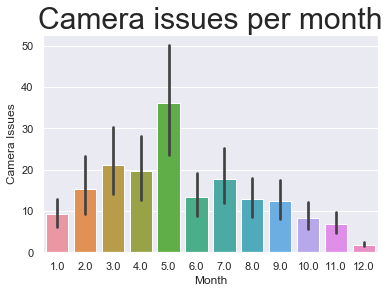

In [78]:
plt.title('Camera issues per month', size = 30)
ax = sns.barplot(x=camera_issue_df1.record_month, y=camera_issue_df1.camera_issue)
ax.set(xlabel='Month', ylabel='Camera Issues')
plt.show()

In [79]:
camera_issue_df = camera_issue_df.groupby(['record_month','state'])['camera_issue'].sum()

camera_issue_df = camera_issue_df.reset_index()
camera_issue_df = camera_issue_df.loc[camera_issue_df['camera_issue']>25]
camera_issue_df.head()

,record_month,state,camera_issue
0,1.0,IL,30.0
1,1.0,MI,46.0
2,2.0,IL,38.0
3,2.0,MI,107.0
4,2.0,PA,30.0


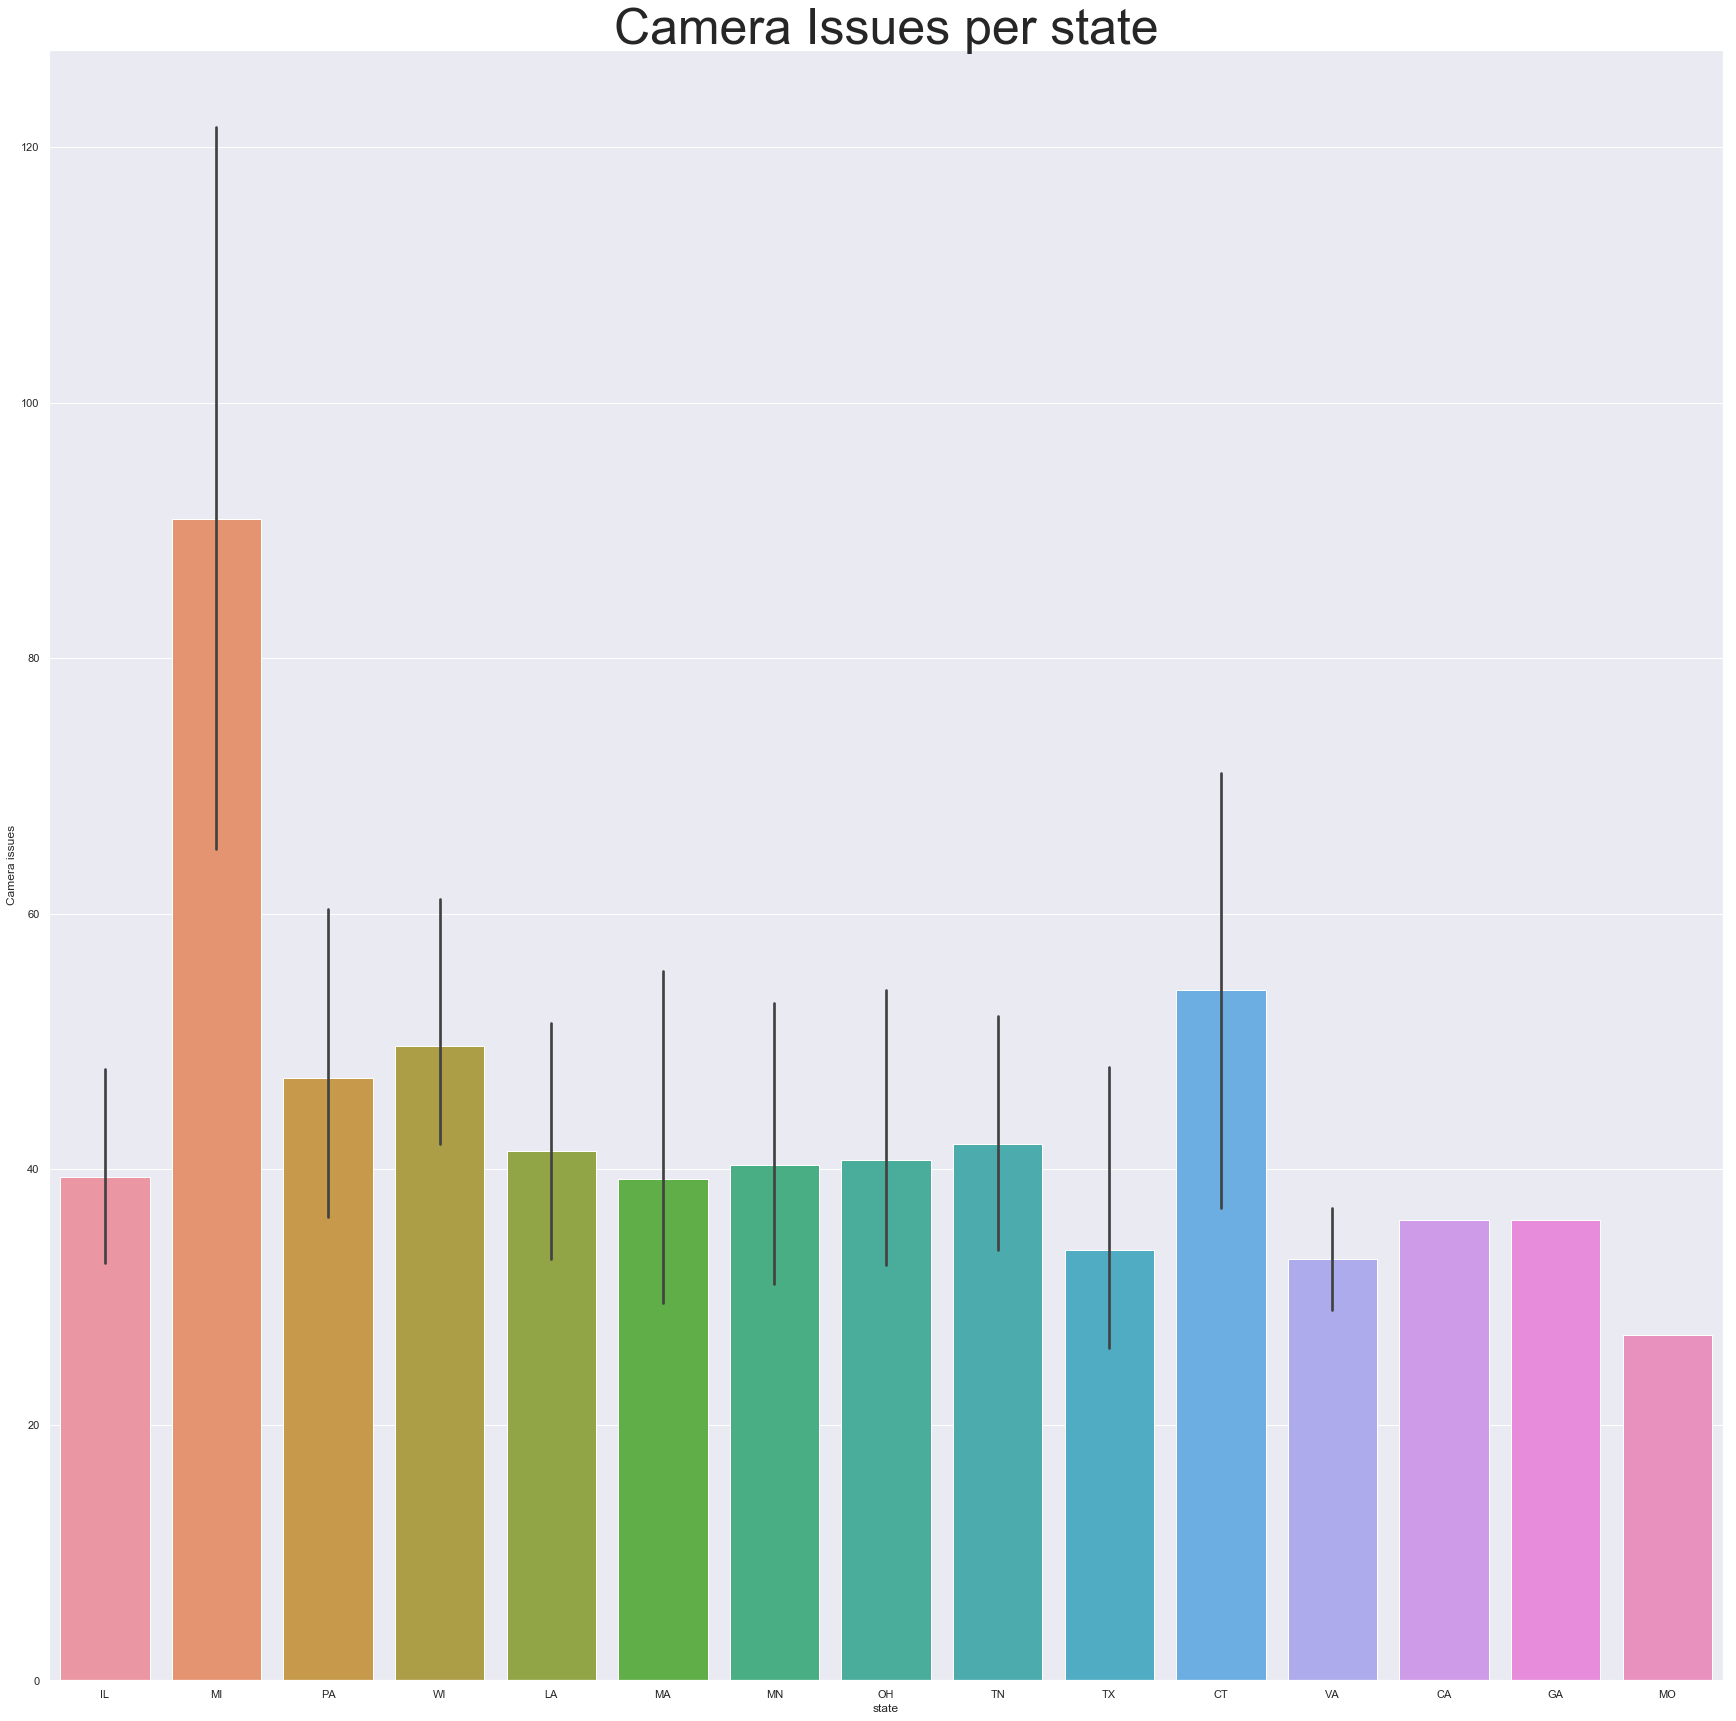

In [80]:
plt.figure(figsize=(30,30))
plt.title('Camera Issues per state', size = 50)
ax = sns.barplot(x=camera_issue_df.state, y=camera_issue_df.camera_issue)
ax.set(xlabel='state', ylabel='Camera issues')
sns.set(font_scale=1)
plt.show()

In [81]:
camera_issue_df = camera_issue_df.groupby(['record_month','state'])['camera_issue'].sum()
camera_issue_df = camera_issue_df.reset_index()
camera_issue_df.head()

,record_month,state,camera_issue
0,1.0,IL,30.0
1,1.0,MI,46.0
2,2.0,IL,38.0
3,2.0,MI,107.0
4,2.0,PA,30.0


In [82]:

pivot_table = camera_issue_df.pivot(camera_issue_df.columns[0], camera_issue_df.columns[1], camera_issue_df.columns[2]).fillna(0)
pivot_table

state,CA,CT,GA,IL,LA,MA,MI,MN,MO,OH,PA,TN,TX,VA,WI
record_month,,,,,,,,,,,,,,,
1.0,0.0,0.0,0.0,30.0,0.0,0.0,46.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.0,0.0,0.0,0.0,38.0,0.0,0.0,107.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,48.0
3.0,0.0,0.0,0.0,47.0,44.0,30.0,123.0,37.0,0.0,31.0,44.0,48.0,26.0,0.0,49.0
4.0,0.0,37.0,0.0,39.0,35.0,34.0,139.0,31.0,0.0,39.0,56.0,41.0,27.0,29.0,50.0
5.0,36.0,71.0,36.0,65.0,61.0,64.0,203.0,53.0,27.0,59.0,89.0,70.0,48.0,37.0,88.0
6.0,0.0,0.0,0.0,0.0,0.0,0.0,74.0,0.0,0.0,0.0,28.0,36.0,0.0,0.0,41.0
7.0,0.0,0.0,0.0,37.0,39.0,29.0,95.0,0.0,0.0,34.0,44.0,41.0,0.0,0.0,44.0
8.0,0.0,0.0,0.0,32.0,28.0,0.0,63.0,0.0,0.0,0.0,44.0,29.0,0.0,0.0,39.0
9.0,0.0,0.0,0.0,27.0,0.0,0.0,55.0,0.0,0.0,0.0,42.0,29.0,0.0,0.0,38.0


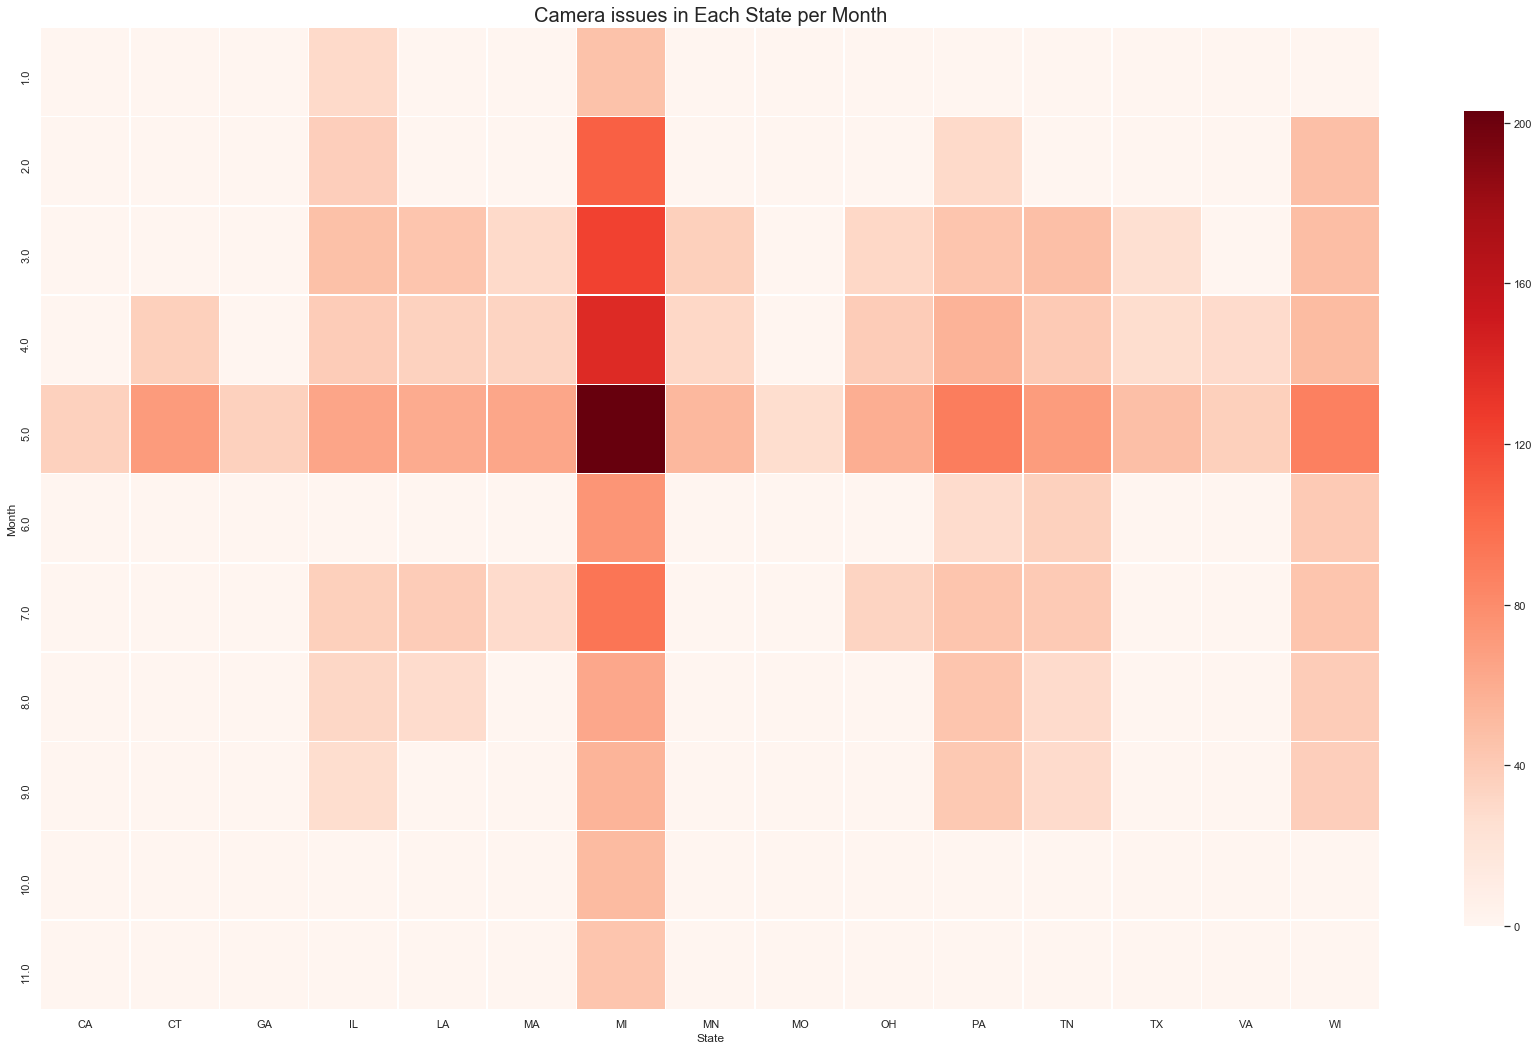

In [83]:
plt.figure(figsize=(30,30))
plt.title('Camera issues in Each State per Month', size = 20)
ax = sns.heatmap(pivot_table, annot = False,cbar_kws={"shrink": .5},  linewidth =.5, square= True,cmap='Reds')
ax.set(xlabel='State', ylabel='Month')
plt.show()

In [84]:
state_month['state'].value_counts().head(20)

MI         47146
WI         24037
PA         21895
TN         19123
IL         16615
OH         14559
MA         13005
MN         13004
LA         12664
VA         10705
TX         10410
CT          9145
CA          8544
GA          8532
VT          6867
Unknown     6152
NY          5425
KY          5299
MO          5272
FL          4813
Name: state, dtype: int64

In [85]:
state_month = state_month.drop(['group_level_5', 'group_level_6'], axis=1)
state_month.head()

,record_month,collision,event_score,camera_issue,driver_id,er_obstruction,state
0,1,0,0,0,NaN,0,WI
1,1,0,0,1,73585,0,NY
2,1,0,0,0,87331,0,CA
3,1,0,0,0,49154,0,WI
4,1,0,0,0,NaN,0,VA


In [86]:
#just collisions per state
state_col = state_month.groupby(['state'])['collision'].sum().reset_index()
state_col.head()

,state,collision
0,AR,2
1,Aurora,1
2,Bay City - Field Services,0
3,Boston Bev/Chem,0
4,Bowling Green Bev/Chem,0


In [87]:
state_col = state_col.loc[state_col['collision']>5]
print(state_col.shape)
state_col.head()

(18, 2)


,state,collision
6,CA,8
7,CT,19
16,GA,13
22,IL,27
24,KY,6


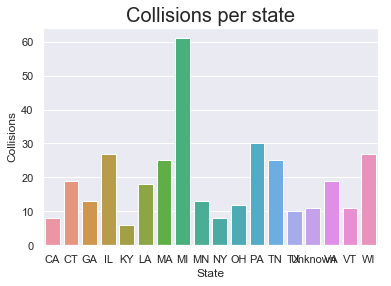

In [88]:
plt.title('Collisions per state', size = 20)
ax = sns.barplot(x=state_col.state, y=state_col.collision)
ax.set(xlabel='State', ylabel='Collisions')
plt.show()

In [89]:
#just collisions per state
state_sco = state_month.groupby(['state'])['event_score'].sum().reset_index()
state_sco.head()

,state,event_score
0,AR,585
1,Aurora,300
2,Bay City - Field Services,42
3,Boston Bev/Chem,19
4,Bowling Green Bev/Chem,0


In [90]:
state_sco = state_sco.loc[state_sco['event_score']>1200]
print(state_sco.shape)
state_sco.head()

(21, 2)


,state,event_score
6,CA,2744
7,CT,3173
14,FL,1596
16,GA,2688
21,IA,1570


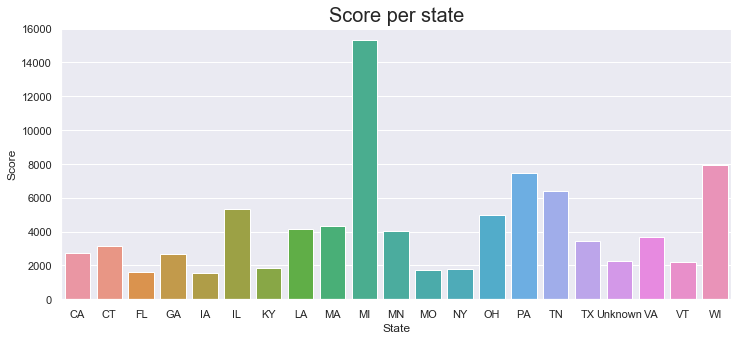

In [91]:
plt.figure(figsize=(12,5))

plt.title('Score per state', size = 20)
ax = sns.barplot(x=state_sco.state, y=state_sco.event_score)
ax.set(xlabel='State', ylabel='Score')
plt.show()

In [92]:
#just collisions per month
month_col = state_month.groupby(['record_month'])['collision'].sum().reset_index()
month_col.head()

,record_month,collision
0,1,36
1,2,21
2,3,30
3,4,27
4,5,39


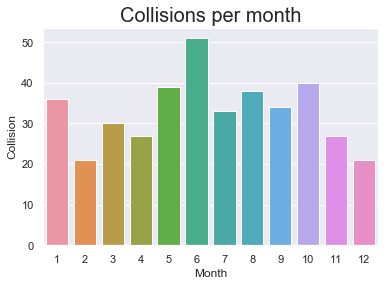

In [93]:
plt.title('Collisions per month', size = 20)
ax = sns.barplot(x=month_col.record_month, y=month_col.collision)
ax.set(xlabel='Month', ylabel='Collision')
plt.show()

In [94]:
#just scores per month
month_sco = state_month.groupby(['record_month'])['event_score'].sum().reset_index()
month_sco.head()

,record_month,event_score
0,1,6107
1,2,5417
2,3,8153
3,4,8314
4,5,10507


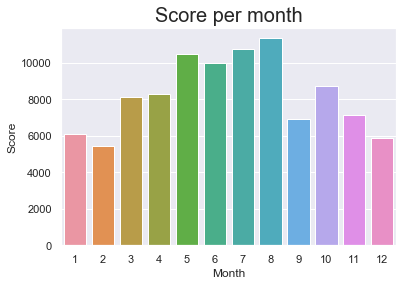

In [95]:
plt.title('Score per month', size = 20)
ax = sns.barplot(x=month_sco.record_month, y=month_sco.event_score)
ax.set(xlabel='Month', ylabel='Score')
plt.show()

In [96]:
#list top states
lstates_top = list(state_col['state'].unique())
#lstates = lstates.remove('Unknown')
lstates_all = list(state_month['state'].unique())

In [97]:
lstates_not_top = [x for x in lstates_all if x not in lstates_top]
state_top_collision = state_month[~state_month['state'].isin(lstates_not_top)]
state_top_collision = state_top_collision[~state_month['state'].isin(['Unknown'])]
state_top_collision['state'].unique()

C:\Users\alonso\Anaconda3\envs\machine_learning\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


array(['WI', 'NY', 'CA', 'VA', 'TX', 'MA', 'IL', 'PA', 'MN', 'OH', 'VT',
       'MI', 'TN', 'LA', 'GA', 'KY', 'CT'], dtype=object)

In [98]:
state_top_collision = state_top_collision.groupby(['record_month','state'])['collision'].sum()
state_top_collision = state_top_collision.reset_index()
state_top_collision.head()

,record_month,state,collision
0,1,CA,1
1,1,CT,1
2,1,GA,1
3,1,IL,1
4,1,KY,0


In [99]:
#pivot_table = state_month_col.pivot('record_month', 'record_month', 'collision')

pivot_table = state_top_collision.pivot(state_top_collision.columns[0], state_top_collision.columns[1], state_top_collision.columns[2]).fillna(0)
pivot_table

state,CA,CT,GA,IL,KY,LA,MA,MI,MN,NY,OH,PA,TN,TX,VA,VT,WI
record_month,,,,,,,,,,,,,,,,,
1,1,1,1,1,0,2,2,7,1,1,2,1,2,0,5,2,4
2,0,0,2,1,0,0,2,3,0,1,1,1,1,1,3,1,0
3,1,1,1,2,2,1,3,8,2,1,1,2,0,1,1,0,1
4,1,1,3,2,2,1,1,3,1,0,1,1,0,0,1,1,3
5,1,5,0,5,0,3,1,5,2,1,1,3,5,2,0,0,3
6,1,4,1,3,1,3,5,7,3,2,2,5,3,0,1,1,2
7,0,0,2,4,0,1,2,4,0,0,0,4,7,1,1,1,3
8,2,1,1,1,0,1,1,6,1,1,3,4,0,3,1,3,1
9,0,2,2,2,0,3,2,4,0,1,0,5,1,0,1,2,4


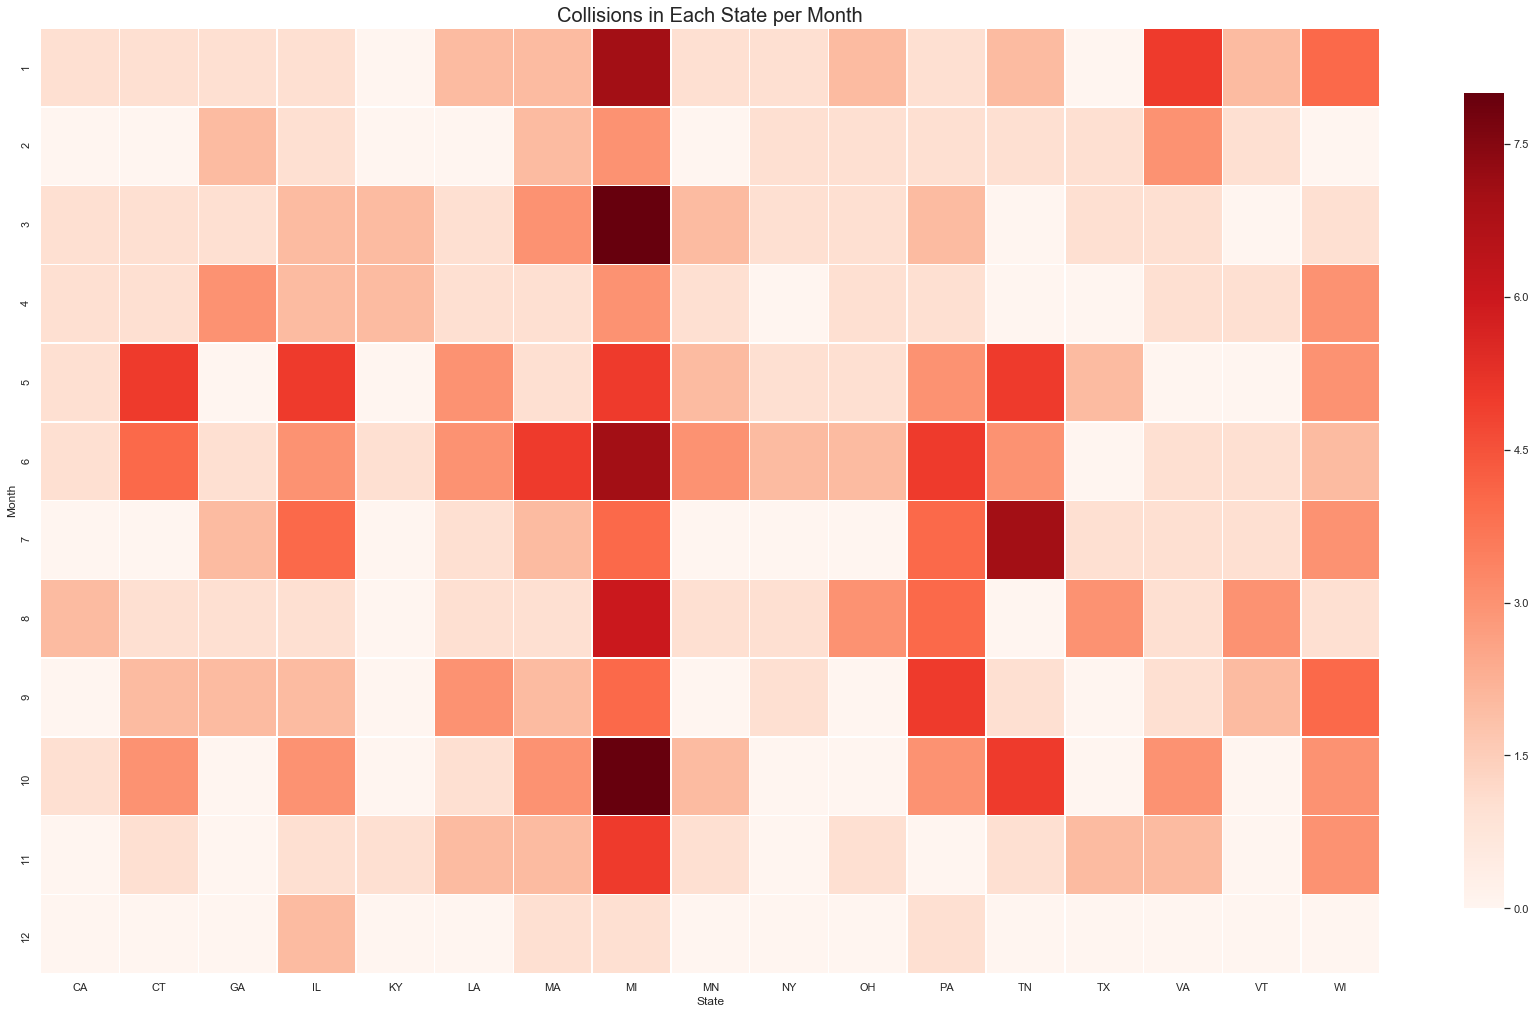

In [100]:
plt.figure(figsize=(30,30))
plt.title('Collisions in Each State per Month', size = 20)
ax = sns.heatmap(pivot_table, annot = False,cbar_kws={"shrink": .5},  linewidth =.5, square= True,cmap='Reds')
ax.set(xlabel='State', ylabel='Month')
plt.show()

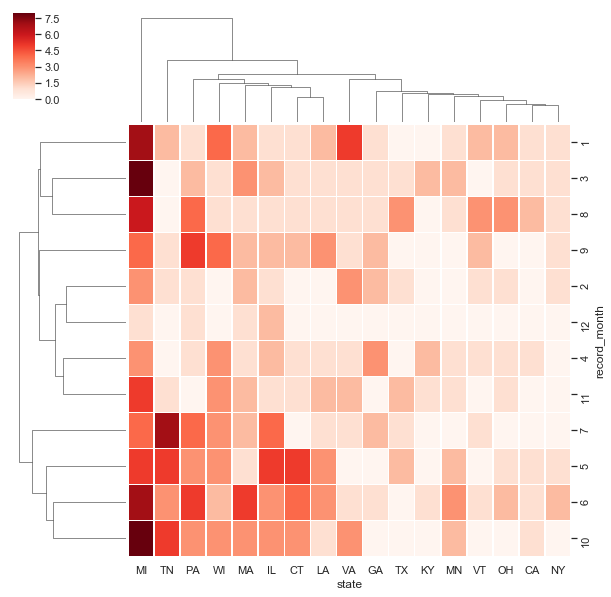

In [101]:
sns.clustermap(pivot_table, cmap='Reds', linewidth=.5 )

In [102]:
#score in states and per month
state_month.head()

,record_month,collision,event_score,camera_issue,driver_id,er_obstruction,state
0,1,0,0,0,NaN,0,WI
1,1,0,0,1,73585,0,NY
2,1,0,0,0,87331,0,CA
3,1,0,0,0,49154,0,WI
4,1,0,0,0,NaN,0,VA


In [103]:
#just collisions per state
state_sco = state_month.groupby(['state'])['event_score'].sum().reset_index()
state_sco.head()

,state,event_score
0,AR,585
1,Aurora,300
2,Bay City - Field Services,42
3,Boston Bev/Chem,19
4,Bowling Green Bev/Chem,0


In [104]:
state_sco = state_sco.loc[state_sco['event_score']>1200]
state_sco.shape

(21, 2)

In [105]:
#list top states
lstates_top = list(state_sco['state'].unique())
#lstates = lstates.remove('Unknown')
lstates_all = list(state_month['state'].unique())

In [106]:
lstates_not_top = [x for x in lstates_all if x not in lstates_top]
state_top_sco = state_month[~state_month['state'].isin(lstates_not_top)]
state_top_sco = state_top_sco[~state_month['state'].isin(['Unknown'])]
state_top_sco['state'].unique()

C:\Users\alonso\Anaconda3\envs\machine_learning\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


array(['WI', 'NY', 'CA', 'VA', 'TX', 'MA', 'IL', 'PA', 'MN', 'OH', 'VT',
       'MI', 'FL', 'TN', 'LA', 'IA', 'GA', 'KY', 'CT', 'MO'], dtype=object)

In [107]:
#score in states and months
state_top_sco = state_top_sco.groupby(['record_month','state'])['collision'].sum()
state_top_sco = state_top_sco.reset_index()
state_top_sco.head()

,record_month,state,collision
0,1,CA,1
1,1,CT,1
2,1,FL,0
3,1,GA,1
4,1,IA,0


In [108]:
pivot_table = state_top_sco.pivot(state_top_sco.columns[0], state_top_sco.columns[1], state_top_sco.columns[2]).fillna(0)
pivot_table

state,CA,CT,FL,GA,IA,IL,KY,LA,MA,MI,MN,MO,NY,OH,PA,TN,TX,VA,VT,WI
record_month,,,,,,,,,,,,,,,,,,,,
1,1,1,0,1,0,1,0,2,2,7,1,0,1,2,1,2,0,5,2,4
2,0,0,1,2,1,1,0,0,2,3,0,0,1,1,1,1,1,3,1,0
3,1,1,1,1,0,2,2,1,3,8,2,0,1,1,2,0,1,1,0,1
4,1,1,1,3,0,2,2,1,1,3,1,0,0,1,1,0,0,1,1,3
5,1,5,1,0,0,5,0,3,1,5,2,0,1,1,3,5,2,0,0,3
6,1,4,0,1,0,3,1,3,5,7,3,0,2,2,5,3,0,1,1,2
7,0,0,0,2,0,4,0,1,2,4,0,0,0,0,4,7,1,1,1,3
8,2,1,0,1,2,1,0,1,1,6,1,0,1,3,4,0,3,1,3,1
9,0,2,0,2,0,2,0,3,2,4,0,3,1,0,5,1,0,1,2,4


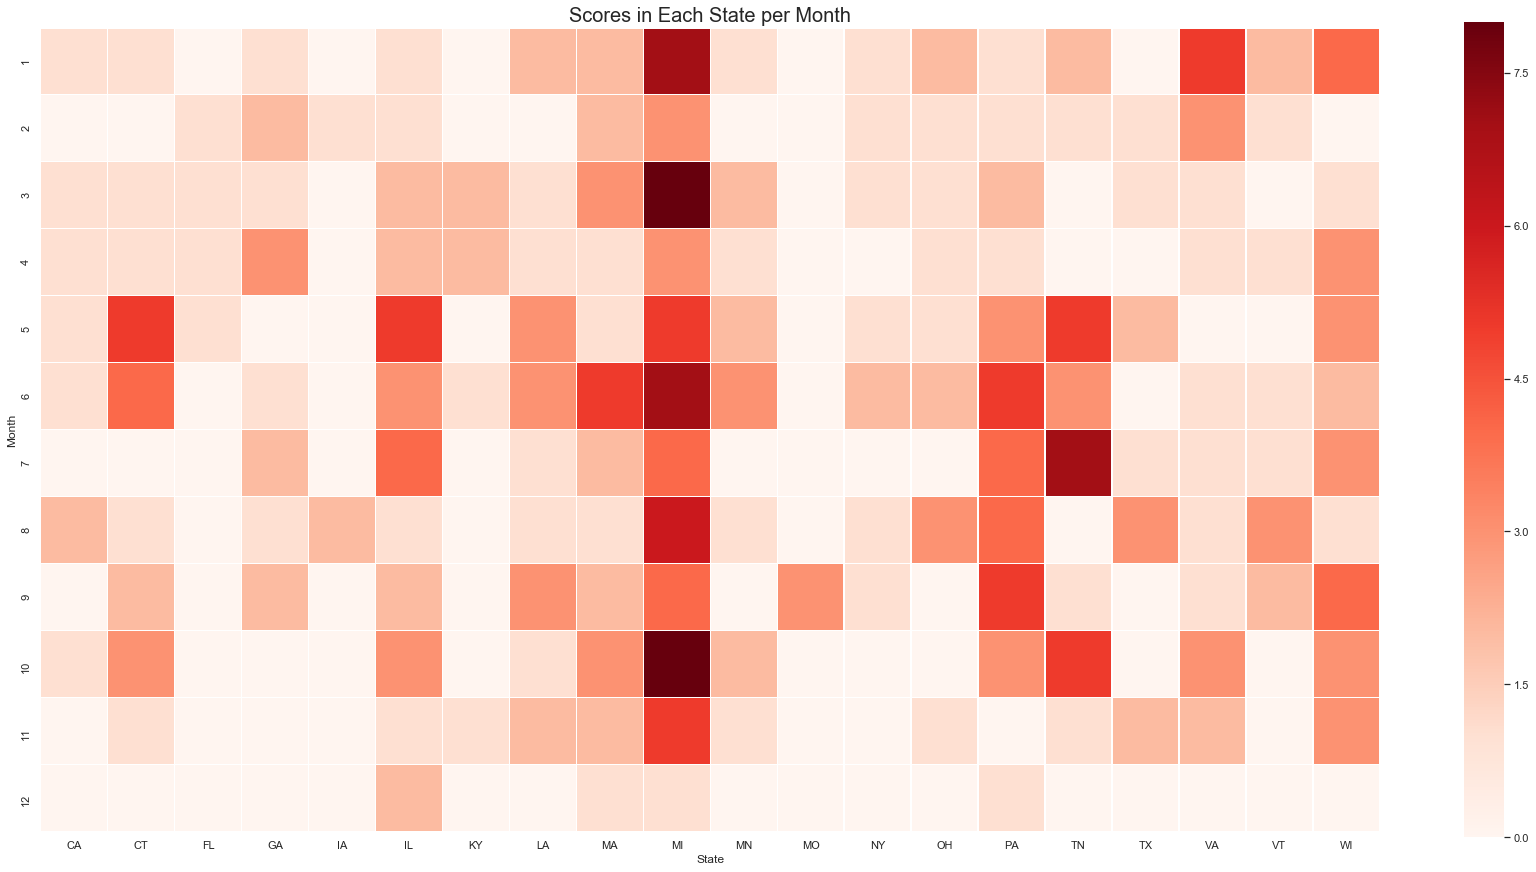

In [109]:
plt.figure(figsize=(30,30))
plt.title('Scores in Each State per Month', size = 20)
ax = sns.heatmap(pivot_table,fmt='.lf',cbar_kws={"shrink": .5}, annot = False,  linewidth =.5, square= True,cmap='Reds' )
ax.set(xlabel='State', ylabel='Month')
plt.show()

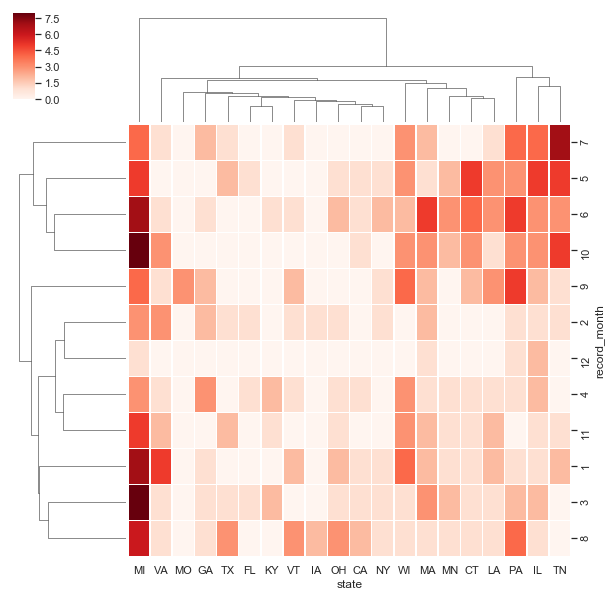

In [110]:
sns.clustermap(pivot_table, cmap='Reds', linewidth=.5 )